# <strong> 수산 BIZ </strong>
[빅콘테스트](https://www.bigcontest.or.kr/index.php)

## 문제정의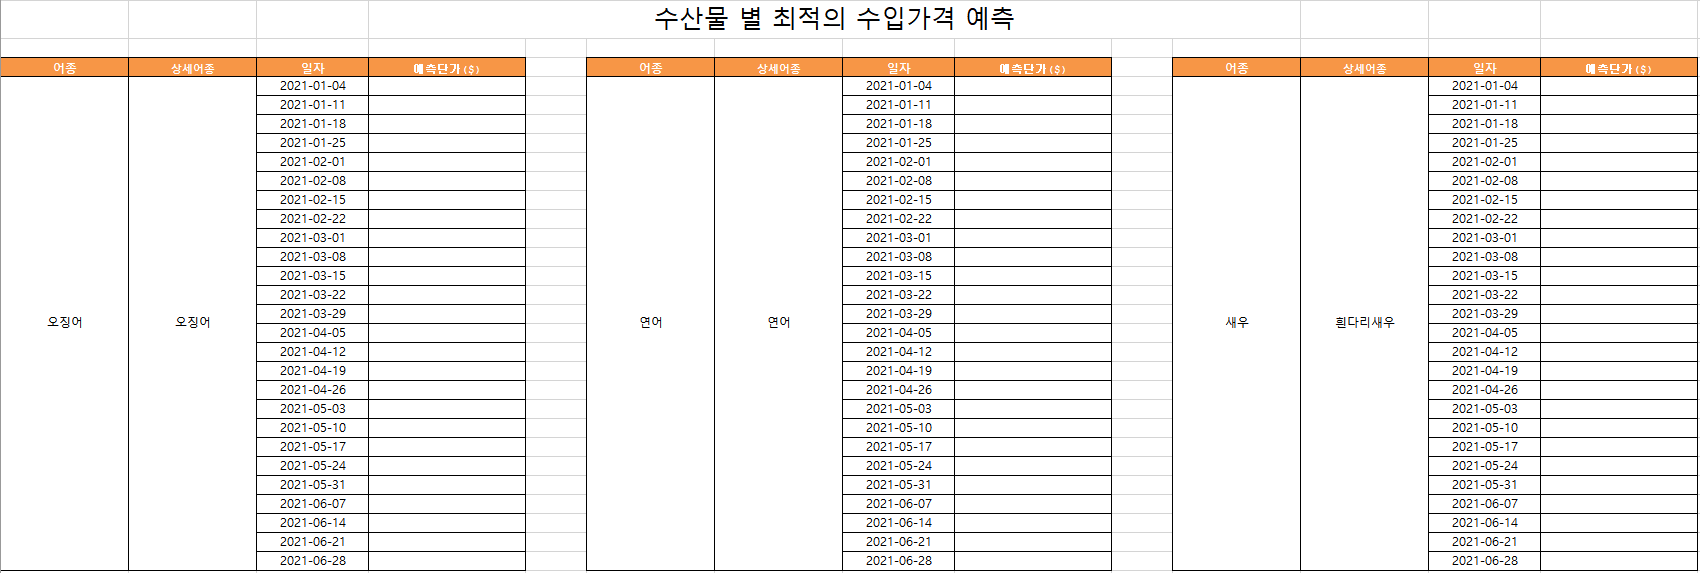

수산물 상세어종(오징어, 연어, 흰다리새우) 별로 2021년 1월~6월의 최적의 수입가격을 예측하는 문제

## 그래프 폰트 한글 설정
아래 셀 실행 후 런타임 다시시작

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv]
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
fc-cache: invalid option -- ']'
usage: fc-cache [-EfrsvVh] [-y SYSROOT] [--error-on-no-fonts] [--force|--really-force] [--sysroot=SYSROOT] [--system-only] [--verbose] [--version] [--help] [dirs]
Build font information caches in [dirs]
(all directories in font configuration by default).

  -E, --error-on-no-fonts  raise an error if no fonts in a directory
  -f, --force              scan directories with apparently valid caches
  -r, --really-force       erase all existing caches, then rescan
  -s, --system-only        scan system-wide directories only
  -y, --sysroot=SYSROOT    prepend SYSROOT to all paths for scanning
  -v, --verbose            display status information while busy
  -V, --version            display font config version and exit
  -h, --help               di

## 라이브러리

In [2]:
import tensorflow as tf
import keras
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
from pandas import DataFrame, Series
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import seaborn as sns


from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from random import *
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM, CuDNNLSTM, Activation
from keras.layers import Embedding
from sklearn.metrics import mean_squared_error
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('max_rows', 300)
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

### 드라이브 마운트
data 폴더 생성 후 제공데이터 업로드

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 오징어 가격 예측

## 데이터프레임
분석에 사용할 제공 데이터프레임

In [4]:
df = pd.read_excel('/content/gdrive/MyDrive/data/2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_문제데이터.xlsx')
df.head()

REG_DATE P_TYPE CTRY_1 CTRY_2 P_PURPOSE CATEGORY_1 CATEGORY_2     P_NAME  \
0 2015-12-28    수산물  아르헨티나  아르헨티나       판매용        갑각류         새우  아르헨티나붉은새우   
1 2015-12-28    수산물    바레인    바레인       판매용        갑각류          게         꽃게   
2 2015-12-28    수산물    바레인    바레인       판매용        갑각류          게         꽃게   
3 2015-12-28    수산물     칠레     칠레       판매용     패류 멍게류         해삼         해삼   
4 2015-12-28    수산물     중국     중국       판매용         어류  서대 박대 페루다         서대   

  P_IMPORT_TYPE    P_PRICE  
0            냉동   7.480000  
1            냉동   2.920000  
2         냉동,절단   3.356352  
3         건조,자숙  18.260870  
4            냉동   4.791340

## 데이터프레임에서 오징어만 추출 후 이상치 제거 및 전처리
이상치 제거에는 IQR 방식을 사용함 이상치를 제거해도 된다고 판단한 이유는 미래에는 천재지변으로 인한 수산물 가격의 급등 혹은 급락이 없을 것이라고 가정한 후에 예측을 진행할 것이기 때문에 제거하기로 결정<br><br>
- 각 년도 별로 데이터가 수집된 일자가 다르기 때문에 월 별로 Week_Number(1년중 몇번째 주차인지)를 기준으로 데이터를 정렬해야 함
- 제공된 데이터 중 16년부터 19년의 데이터를 활용할 것이고 또한 2015년인 데이터는 오직 12월 28일의 데이터만 있기 때문에 활용하지 않으므로 제거해줌
- 년도 별로 수집된 데이터의 시작 요일이 다르므로 구분하여서 Week_Number을 산출하였음 ex) 16년과 17년의 데이터의 수집시작 요일은 일요일이나 18년과 19년의 데이터의 수집시작 요일은 월요일임

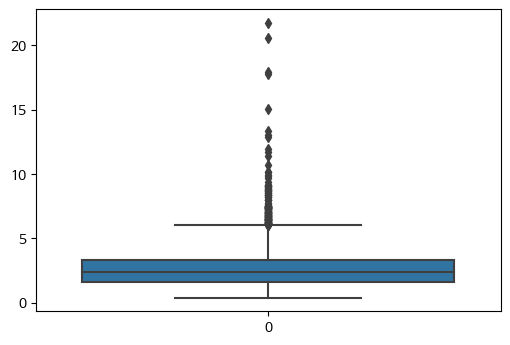

In [5]:
df_squid = df[df['P_NAME'] == '오징어'].drop('CATEGORY_1', axis=1)

# 오징어 가격의 boxplot을 통한 데이터 탐색
plt.figure(dpi=100)
sns.boxplot(data=df_squid['P_PRICE'].values)
plt.show()

In [6]:
quantile_25 = np.percentile(df_squid['P_PRICE'].values, 25)
quantile_75 = np.percentile(df_squid['P_PRICE'].values, 75)
weight = 1.5

IQR = quantile_75 - quantile_25
IQR_weight = IQR*weight
  
lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight
  
outlier_idx = df_squid['P_PRICE'][ (df_squid['P_PRICE'] < lowest) | (df_squid['P_PRICE'] > highest) ].index

df_squid.drop(outlier_idx, axis=0, inplace=True)
df_squid.reset_index(drop=True,inplace=True)

df_squid = df_squid[df_squid['REG_DATE'] != '2015-12-28']

df_squid['YEAR'] = pd.to_datetime(df_squid.REG_DATE).dt.year
df_squid['MONTH'] = pd.to_datetime(df_squid.REG_DATE).dt.month
df_squid16 = df_squid[df_squid['YEAR']== 2016]
df_squid17 = df_squid[df_squid['YEAR']== 2017]
df_squid18 = df_squid[df_squid['YEAR']== 2018]
df_squid19 = df_squid[df_squid['YEAR']== 2019]
df_squid16['Week_Number'] = df_squid16['REG_DATE'].dt.strftime('%U').astype(int)
df_squid17['Week_Number'] = df_squid17['REG_DATE'].dt.strftime('%U').astype(int)
df_squid18['Week_Number'] = df_squid18['REG_DATE'].dt.strftime('%W').astype(int)
df_squid19['Week_Number'] = df_squid19['REG_DATE'].dt.strftime('%W').astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

- 각 년도 별로 가격 변동의 추세를 알아보기 위해 그래프를 그려서 확인함 시각해본 결과 오징어는 추세가 1년을 주기로 갖고 있다고 판단

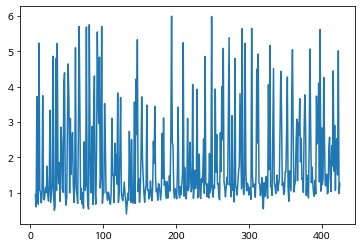

In [7]:
plt.plot(df_squid16['P_PRICE'])
plt.show()

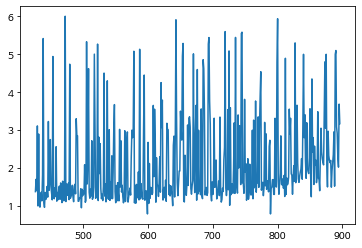

In [8]:
plt.plot(df_squid17['P_PRICE'])
plt.show()

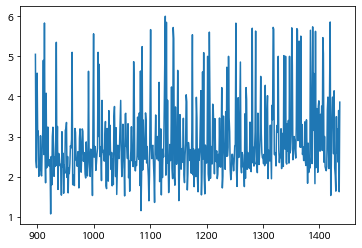

In [9]:
plt.plot(df_squid18['P_PRICE'])
plt.show()

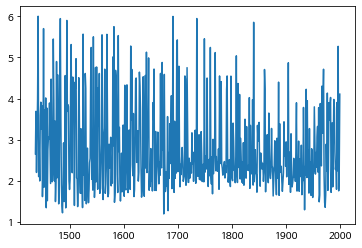

In [10]:
plt.plot(df_squid19['P_PRICE'])
plt.show()

- 년도 별로 나누었던 데이터를 다시 병합한 후 시계열로 구분하기 쉽게 컬럼의 순서를 변경해주었주고 YEAR과 Week_Number를 기준으로 순서대로 정렬해주었음

In [11]:
df_squid = pd.concat([df_squid16,df_squid17,df_squid18,df_squid19])
df_squid = df_squid.reset_index(drop=True)

- 2018년도의 데이터만 53주차가 있으므로 53주차인 데이터를 제거(52주 기준으로 정렬하기 위함)
- 컬럼에서 Identifier가 아닌 CATEGORY_2, P_NAME, MONTH를 제거

In [12]:
df_squid = df_squid[['YEAR','MONTH','Week_Number','CTRY_1',"CTRY_2","CATEGORY_2"	,"P_NAME"	,	"P_PURPOSE",	"P_IMPORT_TYPE",	"P_PRICE"]]
df_squid = df_squid[df_squid['Week_Number'] != 53]
df_squid = df_squid.drop(['CATEGORY_2', 'P_NAME', 'MONTH'], axis=1)
df_squid

YEAR  Week_Number CTRY_1 CTRY_2 P_PURPOSE P_IMPORT_TYPE   P_PRICE
0     2016            1     칠레     칠레       판매용         냉동,다리  0.945644
1     2016            1     페루     페루       판매용       냉동,지느러미  0.600000
2     2016            1     페루     페루   자사제품제조용      냉동,동체,자숙  3.716541
3     2016            1     페루     페루   자사제품제조용         냉동,다리  1.033333
4     2016            1     칠레     칠레       판매용       냉동,지느러미  0.675937
...    ...          ...    ...    ...       ...           ...       ...
1988  2019           52     칠레     칠레       판매용         냉동,동체  2.247963
1989  2019           52     페루     페루       판매용      냉동,동체,자숙  5.269235
1990  2019           52     페루     페루       판매용       냉동,지느러미  1.760060
1991  2019           52     페루     페루       판매용         냉동,동체  2.281843
1992  2019           52     중국     중국       판매용            냉동  4.108244

[1987 rows x 7 columns]

## 라벨인코딩 작업
데이터프레임에서 가격을 예측하는 데 활용할 수 있는 feature가 모두 범주형 데이터(자연어)이므로 모델에 활용하기 위해 정수인코딩을 해주어야 함<br><br>
- df_squid에서 범주형 컬럼들의 값을 모두 text라는 하나의 공간에 담아서 단어를 토큰화 해준 뒤 1번 밖에 나타나지 않은 단어는 제거해주었음

In [13]:
text = df_squid[['CTRY_1',	'CTRY_2', 'P_PURPOSE',	'P_IMPORT_TYPE']].values
text[0]

array(['칠레', '칠레', '판매용', '냉동,다리'], dtype=object)

In [14]:
vocab = {} 
sentences = []

for i in text:
    sentence = i # 단어 토큰화를 수행합니다.
    result = []

    for word in sentence: 
        if len(word) > 0: # 단어 길이가 2이하인 경우에 대하여 추가로 단어를 제거합니다.
            result.append(word)
            if word not in vocab:
                vocab[word] = 0 
            vocab[word] += 1
    sentences.append(result) 
sentences[0]

['칠레', '칠레', '판매용', '냉동,다리']

- vocab은 중복을 제거한 단어와 각 단어에 대한 빈도수가 기록되어져 있음<br>
Key(단어) : Value(각 단어에 대한 빈도수)로 이루어진 dictionary임

In [15]:
vocab

{'나미비아': 1,
 '남아프리카 공화국': 1,
 '냉동': 398,
 '냉동,난포선': 3,
 '냉동,다리': 430,
 '냉동,다리,자숙': 9,
 '냉동,동체': 430,
 '냉동,동체,자숙': 228,
 '냉동,동체,포장횟감': 2,
 '냉동,슬라이스(S)': 22,
 '냉동,자숙': 3,
 '냉동,지느러미': 416,
 '냉동,지느러미,자숙': 46,
 '뉴질랜드': 82,
 '대만': 117,
 '대한민국': 56,
 '러시아': 16,
 '미국': 12,
 '바누아투': 3,
 '반송품(기타)': 4,
 '베트남': 4,
 '스페인': 1,
 '아르헨티나': 100,
 '에콰도르': 8,
 '외화획득용 원료': 27,
 '우루과이': 4,
 '인도네시아': 4,
 '일본': 3,
 '자사제품제조용': 228,
 '중국': 1121,
 '칠레': 1090,
 '판매용': 1728,
 '페루': 1351}

- vocab에서 빈도 수가 높은 순서대로 정렬을 진행

In [16]:
vocab_sorted = sorted(vocab.items(), key = lambda x:x[1], reverse = True)

- 높은 빈도 수를 가진 단어일수록 낮은 정수 인덱스를 부여함 또한 빈도 수가 1인 단어들은 제거

In [17]:
word_to_index = {}
i=0
for (word, frequency) in vocab_sorted :
    if frequency > 1 : # 정제(Cleaning) 챕터에서 언급했듯이 빈도수가 적은 단어는 제외한다.
        i=i+1
        word_to_index[word] = i
word_to_index

{'냉동': 8,
 '냉동,난포선': 27,
 '냉동,다리': 5,
 '냉동,다리,자숙': 20,
 '냉동,동체': 6,
 '냉동,동체,자숙': 10,
 '냉동,동체,포장횟감': 30,
 '냉동,슬라이스(S)': 17,
 '냉동,자숙': 29,
 '냉동,지느러미': 7,
 '냉동,지느러미,자숙': 15,
 '뉴질랜드': 13,
 '대만': 11,
 '대한민국': 14,
 '러시아': 18,
 '미국': 19,
 '바누아투': 28,
 '반송품(기타)': 22,
 '베트남': 23,
 '아르헨티나': 12,
 '에콰도르': 21,
 '외화획득용 원료': 16,
 '우루과이': 25,
 '인도네시아': 24,
 '일본': 26,
 '자사제품제조용': 9,
 '중국': 3,
 '칠레': 4,
 '판매용': 1,
 '페루': 2}

- vocab에 존재하지 않는 단어들을 Out Of Vocabulary(OOV)라는 단어로 새롭게 추가하고, vocab에 없는 단어들을 OOV의 인덱스로 인코딩 함

In [18]:
word_to_index['OOV'] = len(word_to_index) + 1

- word_to_index를 사용하여 sentences의 모든 단어들을 맵핑되는 정수로 인코딩 후에 인코딩 된 값들로 df의 범주형 값들을 교체해 주었음

In [19]:
encoded = []
for s in sentences:
    temp = []
    for w in s:
        try:
            temp.append(word_to_index[w])
        except KeyError:
            temp.append(word_to_index['OOV'])
    encoded.append(temp)
encoded[0]

[4, 4, 1, 5]

In [20]:
df_squid[['CTRY_1',	'CTRY_2', 'P_PURPOSE',	'P_IMPORT_TYPE']] = encoded
df_squid

YEAR  Week_Number  CTRY_1  CTRY_2  P_PURPOSE  P_IMPORT_TYPE   P_PRICE
0     2016            1       4       4          1              5  0.945644
1     2016            1       2       2          1              7  0.600000
2     2016            1       2       2          9             10  3.716541
3     2016            1       2       2          9              5  1.033333
4     2016            1       4       4          1              7  0.675937
...    ...          ...     ...     ...        ...            ...       ...
1988  2019           52       4       4          1              6  2.247963
1989  2019           52       2       2          1             10  5.269235
1990  2019           52       2       2          1              7  1.760060
1991  2019           52       2       2          1              6  2.281843
1992  2019           52       3       3          1              8  4.108244

[1987 rows x 7 columns]

- YEAR와 Week_Number로 groupby를 진행 한 뒤 각 주차별로 평균을 산출하였음 빈도 수를 기준으로 인코딩 된 값들의 평균과 각 주차별로 평균으로 이루어진 값으로 df_squid를 재정의

In [21]:
df_squid = df_squid.groupby(['YEAR', 'Week_Number']).mean()

## 모델링
모델은 지난 1년 간의 데이터로 1년 후를 예측하는 모델이므로 Target은 1년 후의 실제 가격임

In [22]:
df_squid['Target'] = df_squid['P_PRICE'].shift(-52)
df_squid

CTRY_1    CTRY_2  P_PURPOSE  P_IMPORT_TYPE   P_PRICE  \
YEAR Week_Number                                                           
2016 1            2.750000  2.750000   3.000000       6.875000  1.787152   
     2            3.000000  3.000000   4.428571       6.571429  1.345855   
     3            3.700000  3.700000   2.600000       7.700000  1.675178   
     4            2.666667  6.333333   2.333333       7.166667  2.185579   
     5            4.700000  3.600000   2.600000       7.500000  2.148819   
     7            3.285714  3.285714   3.285714       7.285714  2.103069   
     8            3.636364  5.636364   3.090909       8.636364  1.902785   
     9            3.166667  3.166667   2.333333       8.000000  2.426714   
     10           2.714286  2.714286   4.285714       8.714286  1.885128   
     11           2.600000  2.600000   2.600000       7.800000  2.075563   
     12           3.142857  3.142857   2.142857       7.714286  2.050616   
     13           3.100000  3.100000   1.800000       9.800000  2.943038   
     14           3.166667  3.166667   1.000000       6.500000  1.618997   
     15           3.600000  3.600000   4.000000       6.000000  0.872816   
     16           4.545455  4.545455   4.545455       8.636364  1.782980   
     17           5.166667  3.333333   2.333333       7.000000  1.590523   
     18           5.833333  5.833333   1.000000       6.166667  0.848935   
     19           3.375000  3.375000   3.000000       7.375000  1.375417   
     20           3.777778  3.777778   1.888889       7.333333  2.299896   
     21           2.857143  2.857143   1.000000       9.714286  1.706284   
     22           5.600000  3.400000   2.600000       7.000000  1.536506   
     23           3.400000  3.400000   1.000000       5.800000  1.019695   
     24           3.285714  3.285714   1.000000       7.000000  1.723397   
     25           3.800000  3.800000   2.600000       5.600000  1.077489   
     26           3.125000  3.125000   2.000000       6.750000  1.607324   
     27           4.363636  3.363636   2.454545       7.454545  1.899094   
     28           3.142857  3.142857   3.285714       6.285714  1.409832   
     29           4.333333  3.111111   1.888889       6.777778  1.626713   
     30           4.000000  4.000000   1.000000       7.000000  1.947026   
     31           3.166667  3.166667   2.333333       7.000000  1.650361   
     32           3.000000  3.000000   2.333333       6.833333  1.691165   
     33           2.769231  2.769231   2.846154       7.538462  1.624946   
     34           2.750000  2.750000   2.000000       7.750000  1.796924   
     35           2.857143  3.714286   3.285714       7.571429  1.811459   
     36           3.700000  4.300000   3.400000       7.800000  2.118434   
     37           3.142857  3.142857   3.285714       7.000000  2.105643   
     38           3.111111  3.111111   1.888889       6.777778  1.722667   
     39           2.666667  3.333333   3.666667       7.888889  2.195228   
     40           4.833333  4.833333   4.833333       7.000000  1.892673   
     41           4.222222  4.222222   2.777778       6.666667  1.633932   
     42           6.142857  4.571429   3.285714       7.142857  2.392848   
     43           3.285714  3.285714   2.142857       6.000000  1.039853   
     44           3.888889  3.888889   1.888889       6.555556  1.935322   
     45           6.333333  4.666667   1.000000       6.500000  1.986788   
     46           6.000000  3.900000   1.800000       6.700000  1.918872   
     47           4.312500  3.625000   3.000000       7.250000  2.009874   
     48           6.583333  3.833333   3.416667       8.333333  2.252496   
     49           5.000000  3.777778   2.777778       7.888889  2.366863   
     50           4.133333  3.400000   3.466667       7.266667  2.137302   
     51           4.538462  4.538462   1.615385       6.846154  1.734149   
     52           5.500000  4.583333   1.666667       7.833333  2.31

- 16,17,18년 데이터로 각각 1년 후를 예측하는 모델을 만들고 그 모델에 19년도의 데이터를 넣어서 20년을 예측

In [23]:
df_squid_learn = df_squid[df_squid['Target'].notnull()]
df_squid_predict = df_squid[df_squid['Target'].isnull()]
X = df_squid_learn[['CTRY_1',	'CTRY_2',	'P_PURPOSE', 'P_IMPORT_TYPE',	'P_PRICE']].values.reshape(-1,1,5)
y = df_squid_learn['Target'].values.reshape(-1,1,1)

- 가격은 모두 달러로 나타나며 예측하려는 값도 동일한 단위이므로 스케일링을 진행하지 않았음<br>
시계열적 특성을 반영하기 위해서 LSTM 모델을 사용하였고 1년의 추세를 반영하기 위해 Input_shape는 행(52주),열(Feature 갯수=5개)로 투입하였음

In [24]:
with tf.device('/device:GPU:0'):
  model = Sequential()
  model.add(layers.LSTM(100, input_shape=(52,5), activation='relu'))
  model.add(layers.Dense(30))
  model.add(layers.Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.fit(X, y, epochs=1000, batch_size=50)

  # model.save("squid.h5")
  model = tf.keras.models.load_model("/content/gdrive/MyDrive/data/squid.h5")

Epoch 1/1000
4/4 [==============================] - 2s 9ms/step - loss: 8.0253
Epoch 2/1000
4/4 [==============================] - 0s 7ms/step - loss: 5.7490
Epoch 3/1000
4/4 [==============================] - 0s 8ms/step - loss: 3.6988
Epoch 4/1000
4/4 [==============================] - 0s 8ms/step - loss: 1.9751
Epoch 5/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.7388
Epoch 6/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.3132
Epoch 7/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.5782
Epoch 8/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.6267
Epoch 9/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3852
Epoch 10/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2858
Epoch 11/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3228
Epoch 12/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3715
Epoch 13/1000
4/4 [==========================

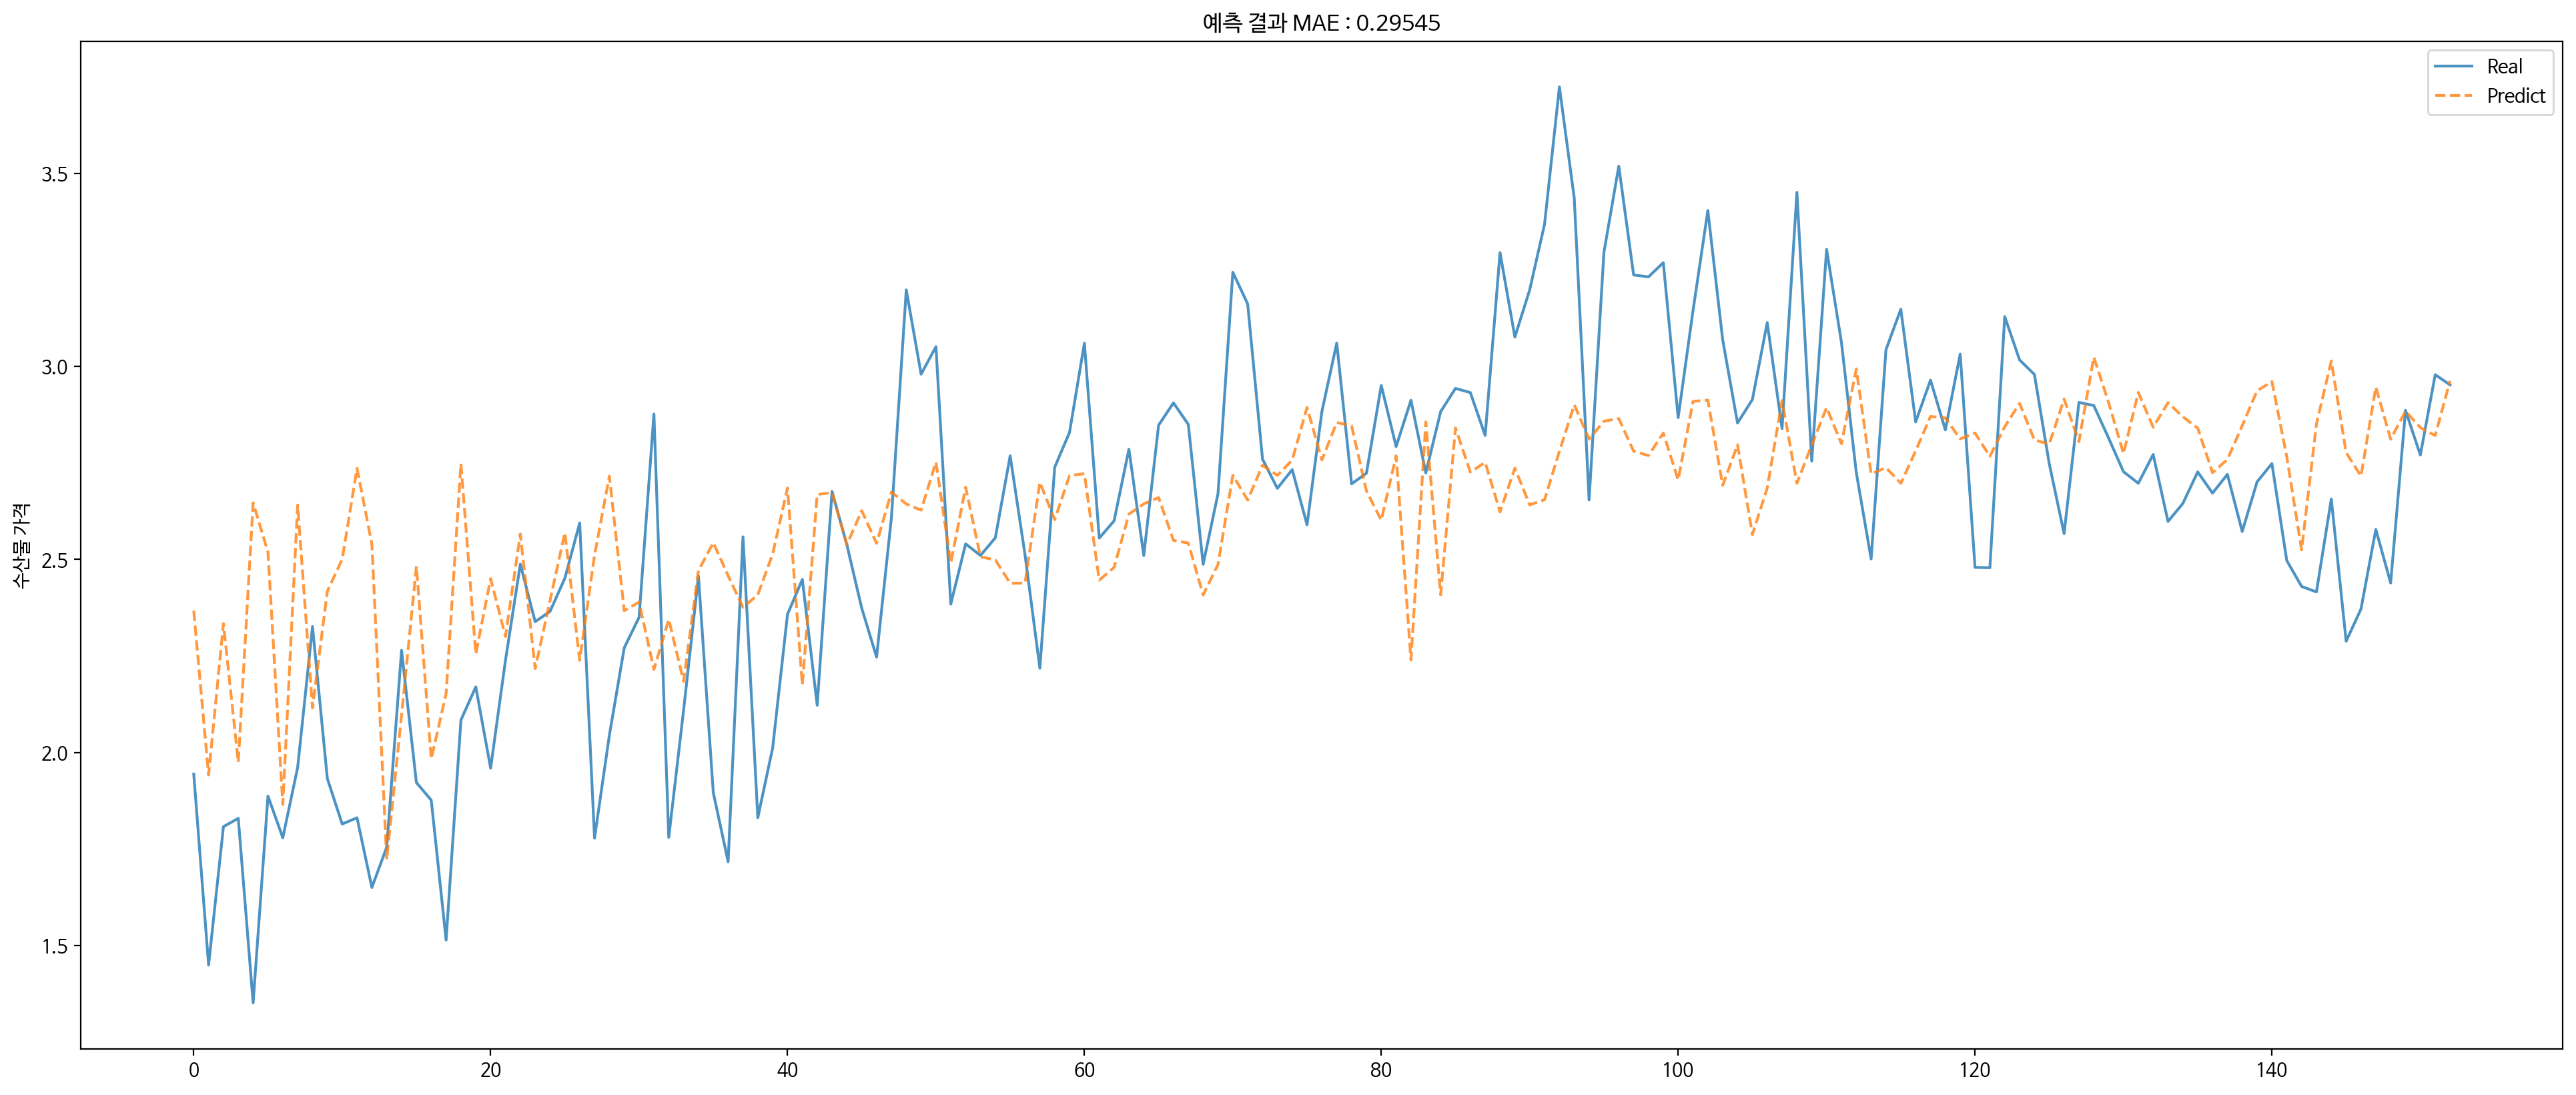

In [25]:
y_pred = model.predict(X)

MAE = mean_absolute_error(y.reshape(-1,1), y_pred.reshape(-1, 1))

plt.figure(figsize=(24, 10),dpi=200)
plt.title('예측 결과'+   ' MAE : ' + str(MAE)[:7])
plt.ylabel('수산물 가격')
plt.plot(np.array(y).reshape(-1,1), alpha = 0.8, label = 'Real')
plt.plot(y_pred.reshape(-1, 1), alpha = 0.8,linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

## Input데이터인 20년도 데이터프레임 정의 및 전처리

In [26]:
df20 = pd.read_excel('/content/gdrive/MyDrive/data/2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_자율평가데이터.xlsx')
df20.head()

REG_DATE P_TYPE CTRY_1 CTRY_2 P_PURPOSE CATEGORY_1 CATEGORY_2  P_NAME  \
0 2020-01-06    수산물     호주     일본       판매용         어류    참치 새치류   남방참다랑어   
1 2020-01-06    수산물     칠레     일본   자사제품제조용         어류         연어     은연어   
2 2020-01-06    수산물     중국     중국       판매용         어류        도다리    강도다리   
3 2020-01-06    수산물     중국     중국       판매용         어류         복어     자주복   
4 2020-01-06    수산물     중국     중국       판매용         어류         복어     은밀복   

  P_IMPORT_TYPE    P_PRICE  
0         냉동,목살   4.883410  
1            냉동   5.391782  
2             활   6.764961  
3             활  18.499875  
4            냉동   3.071645

- 20년도 데이터에서 오징어만을 추출하여 이상치를 IQR로 제거하고 주차별로 정렬하기 위한 전처리 작업 수행

In [27]:
df_squid20 = df20[df20['P_NAME'] == '오징어'].drop('CATEGORY_1', axis=1)

quantile_25 = np.percentile(df_squid20['P_PRICE'].values, 25)
quantile_75 = np.percentile(df_squid20['P_PRICE'].values, 75)
weight = 1.5

IQR = quantile_75 - quantile_25
IQR_weight = IQR*weight
  
lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight
  
outlier_idx = df_squid20['P_PRICE'][ (df_squid20['P_PRICE'] < lowest) | (df_squid20['P_PRICE'] > highest) ].index

df_squid20.drop(outlier_idx, axis=0, inplace=True)
df_squid20.reset_index(drop=True,inplace=True)

df_squid20['YEAR'] = pd.to_datetime(df_squid20.REG_DATE).dt.year
df_squid20['MONTH'] = pd.to_datetime(df_squid20.REG_DATE).dt.month

df_squid20['Week_Number'] = df_squid20['REG_DATE'].dt.strftime('%U').astype(int)


In [28]:
df_squid20 = df_squid20[['YEAR','MONTH','Week_Number','CTRY_1',"CTRY_2","CATEGORY_2"	,"P_NAME"	,	"P_PURPOSE",	"P_IMPORT_TYPE",	"P_PRICE"]]
df_squid20 = df_squid20.drop(['CATEGORY_2', 'P_NAME', 'MONTH'], axis=1)
df_squid20

YEAR  Week_Number CTRY_1 CTRY_2 P_PURPOSE P_IMPORT_TYPE   P_PRICE
0    2020            1     중국     중국       판매용    냉동,슬라이스(S)  2.706303
1    2020            1     중국     중국       판매용         냉동,다리  1.940000
2    2020            1     페루     칠레       판매용         냉동,동체  2.195883
3    2020            1     페루     칠레       판매용       냉동,지느러미  1.922647
4    2020            1     페루     페루       판매용         냉동,다리  2.855495
..    ...          ...    ...    ...       ...           ...       ...
606  2020           52     페루     페루       판매용         냉동,다리  2.160000
607  2020           52     페루     페루       판매용      냉동,동체,자숙  2.910000
608  2020           52     페루     페루       판매용       냉동,지느러미  1.330000
609  2020           52     중국     중국       판매용         냉동,동체  2.090000
610  2020           52     중국     중국       판매용            냉동  3.150000

[611 rows x 7 columns]

- 20년도 오징어 가격의 추세 확인을 위한 그래프를 그렸으며 동일하게 1년의 추세성이 있다고 판단

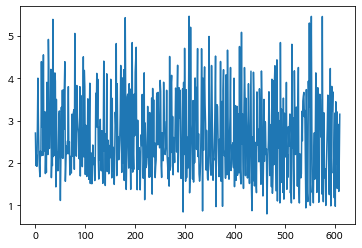

In [29]:
plt.plot(df_squid20['P_PRICE'])
plt.show()

- 위에서 인코딩한 데이터를 끌어와서 빈도 수 기준으로 동일하게 인코딩 후 범주형 데이터 재정의

In [30]:
text = df_squid20[['CTRY_1',	'CTRY_2', 'P_PURPOSE',	'P_IMPORT_TYPE']].values
text[0]

array(['중국', '중국', '판매용', '냉동,슬라이스(S)'], dtype=object)

In [31]:
sentences = []

for i in text:
    sentence = i # 단어 토큰화를 수행합니다.
    result = []

    for word in sentence: 
        if len(word) > 0: # 단어 길이가 2이하인 경우에 대하여 추가로 단어를 제거합니다.
            result.append(word)            
    sentences.append(result) 
sentences[0]

['중국', '중국', '판매용', '냉동,슬라이스(S)']

In [32]:
encoded = []
for s in sentences:
    temp = []
    for w in s:
        try:
            temp.append(word_to_index[w])
        except KeyError:
            temp.append(word_to_index['OOV'])
    encoded.append(temp)
encoded[0]

[3, 3, 1, 17]

In [33]:
df_squid20[['CTRY_1',	'CTRY_2', 'P_PURPOSE',	'P_IMPORT_TYPE']] = encoded
df_squid20

YEAR  Week_Number  CTRY_1  CTRY_2  P_PURPOSE  P_IMPORT_TYPE   P_PRICE
0    2020            1       3       3          1             17  2.706303
1    2020            1       3       3          1              5  1.940000
2    2020            1       2       4          1              6  2.195883
3    2020            1       2       4          1              7  1.922647
4    2020            1       2       2          1              5  2.855495
..    ...          ...     ...     ...        ...            ...       ...
606  2020           52       2       2          1              5  2.160000
607  2020           52       2       2          1             10  2.910000
608  2020           52       2       2          1              7  1.330000
609  2020           52       3       3          1              6  2.090000
610  2020           52       3       3          1              8  3.150000

[611 rows x 7 columns]

- Year와 Week_Number로 groupby한 평균 값으로 df_squid20을 재정의

In [34]:
df_squid20 = df_squid20.groupby(['YEAR', 'Week_Number']).mean()
df_squid20

CTRY_1    CTRY_2  P_PURPOSE  P_IMPORT_TYPE   P_PRICE
YEAR Week_Number                                                        
2020 1            3.533333  3.066667   1.533333       7.400000  2.694026
     2            3.461538  3.461538   1.615385       7.692308  2.933695
     3            5.583333  5.583333   1.000000       7.666667  2.933224
     4            2.800000  2.800000   1.000000       7.500000  2.573288
     5            6.250000  6.250000   1.000000       6.750000  2.156142
     6            2.000000  2.000000   3.666667       8.666667  3.181970
     7            2.200000  2.200000   4.200000       7.200000  2.915586
     8            8.166667  8.166667   1.000000       6.666667  2.419078
     9            5.545455  4.090909   1.727273       8.272727  3.053760
     10           4.083333  4.083333   2.916667       7.750000  2.730568
     11           3.000000  3.000000   1.888889       7.111111  2.741034
     12           3.142857  3.142857   1.000000       6.428571  2.356233
     13           3.000000  3.250000   1.000000       7.625000  1.916776
     14           6.666667  4.222222   1.000000       7.222222  2.918297
     15           5.333333  4.111111   1.000000       7.222222  2.510407
     16           4.818182  4.818182   1.000000       6.727273  2.379347
     17           4.375000  4.375000   1.000000       6.875000  2.474297
     18           5.166667  3.833333   1.666667       9.250000  2.679031
     19           5.466667  5.466667   5.533333       8.333333  3.100046
     20           5.428571  5.428571   3.142857       7.214286  2.705007
     21           8.400000  5.700000   1.000000       8.300000  2.870999
     22           4.000000  4.000000   1.000000       6.400000  2.475941
     23           3.916667  3.000000   1.000000       6.666667  2.305804
     24           5.230769  4.384615   1.000000       7.000000  2.525424
     25           6.153846  5.307692   1.000000       7.846154  2.757299
     26           4.909091  3.909091   1.000000       6.727273  2.583430
     27           2.923077  2.923077   1.615385       7.076923  2.660586
     28           4.357143  4.357143   1.000000       7.785714  2.949701
     29           4.727273  4.727273   3.727273       7.363636  2.732656
     30           4.214286  4.214286   1.571429       7.000000  2.768075
     31           6.533333  5.466667   1.533333       7.133333  2.982761
     32           3.866667  3.866667   2.066667       7.533333  2.794052
     33           3.583333  3.583333   1.666667       6.916667  2.691555
     34           6.538462  6.538462   1.000000       7.000000  2.549271
     35           4.133333  4.133333   4.066667       6.866667  2.614699
     36           5.916667  5.916667   1.666667       7.083333  2.676716
     37           5.285714  5.285714   1.571429       7.928571  2.710624
     38           5.611111  5.000000   2.777778       7.611111  2.662821
     39           3.727273  3.727273   1.000000       6.818182  2.296022
     40           5.666667  5.666667   1.666667       7.250000  2.635848
     41           7.842105  7.263158   2.684211       7.473684  2.386459
     42           6.750000  6.750000   1.666667       7.500000  2.860929
     43           7.583333  7.583333   2.333333       7.583333  2.530579
     44           7.235294  7.235294   1.941176       7.352941  2.423849
     45           7.714286  6.928571   2.142857       7.142857  2.549661
     46           6.388889  5.777778   3.222222       7.222222  2.610570
     47           6.181818  5.272727   2.454545       7.545455  2.724792
     48           5.000000  5.000000   1.800000       7.300000  2.480262
     49           3.333333  3.333333   2.777778       7.555556  2.898781
     50           4.200000  4.200000   2.600000       7.600000  2.241298
     51           4.777778  3.555556   1.888889       7.333333  2.601302
     52           3.875000  2.500000   1.000000       6.875000  2.277500

- 19년도 가격으로 20년도를 예측한 결과

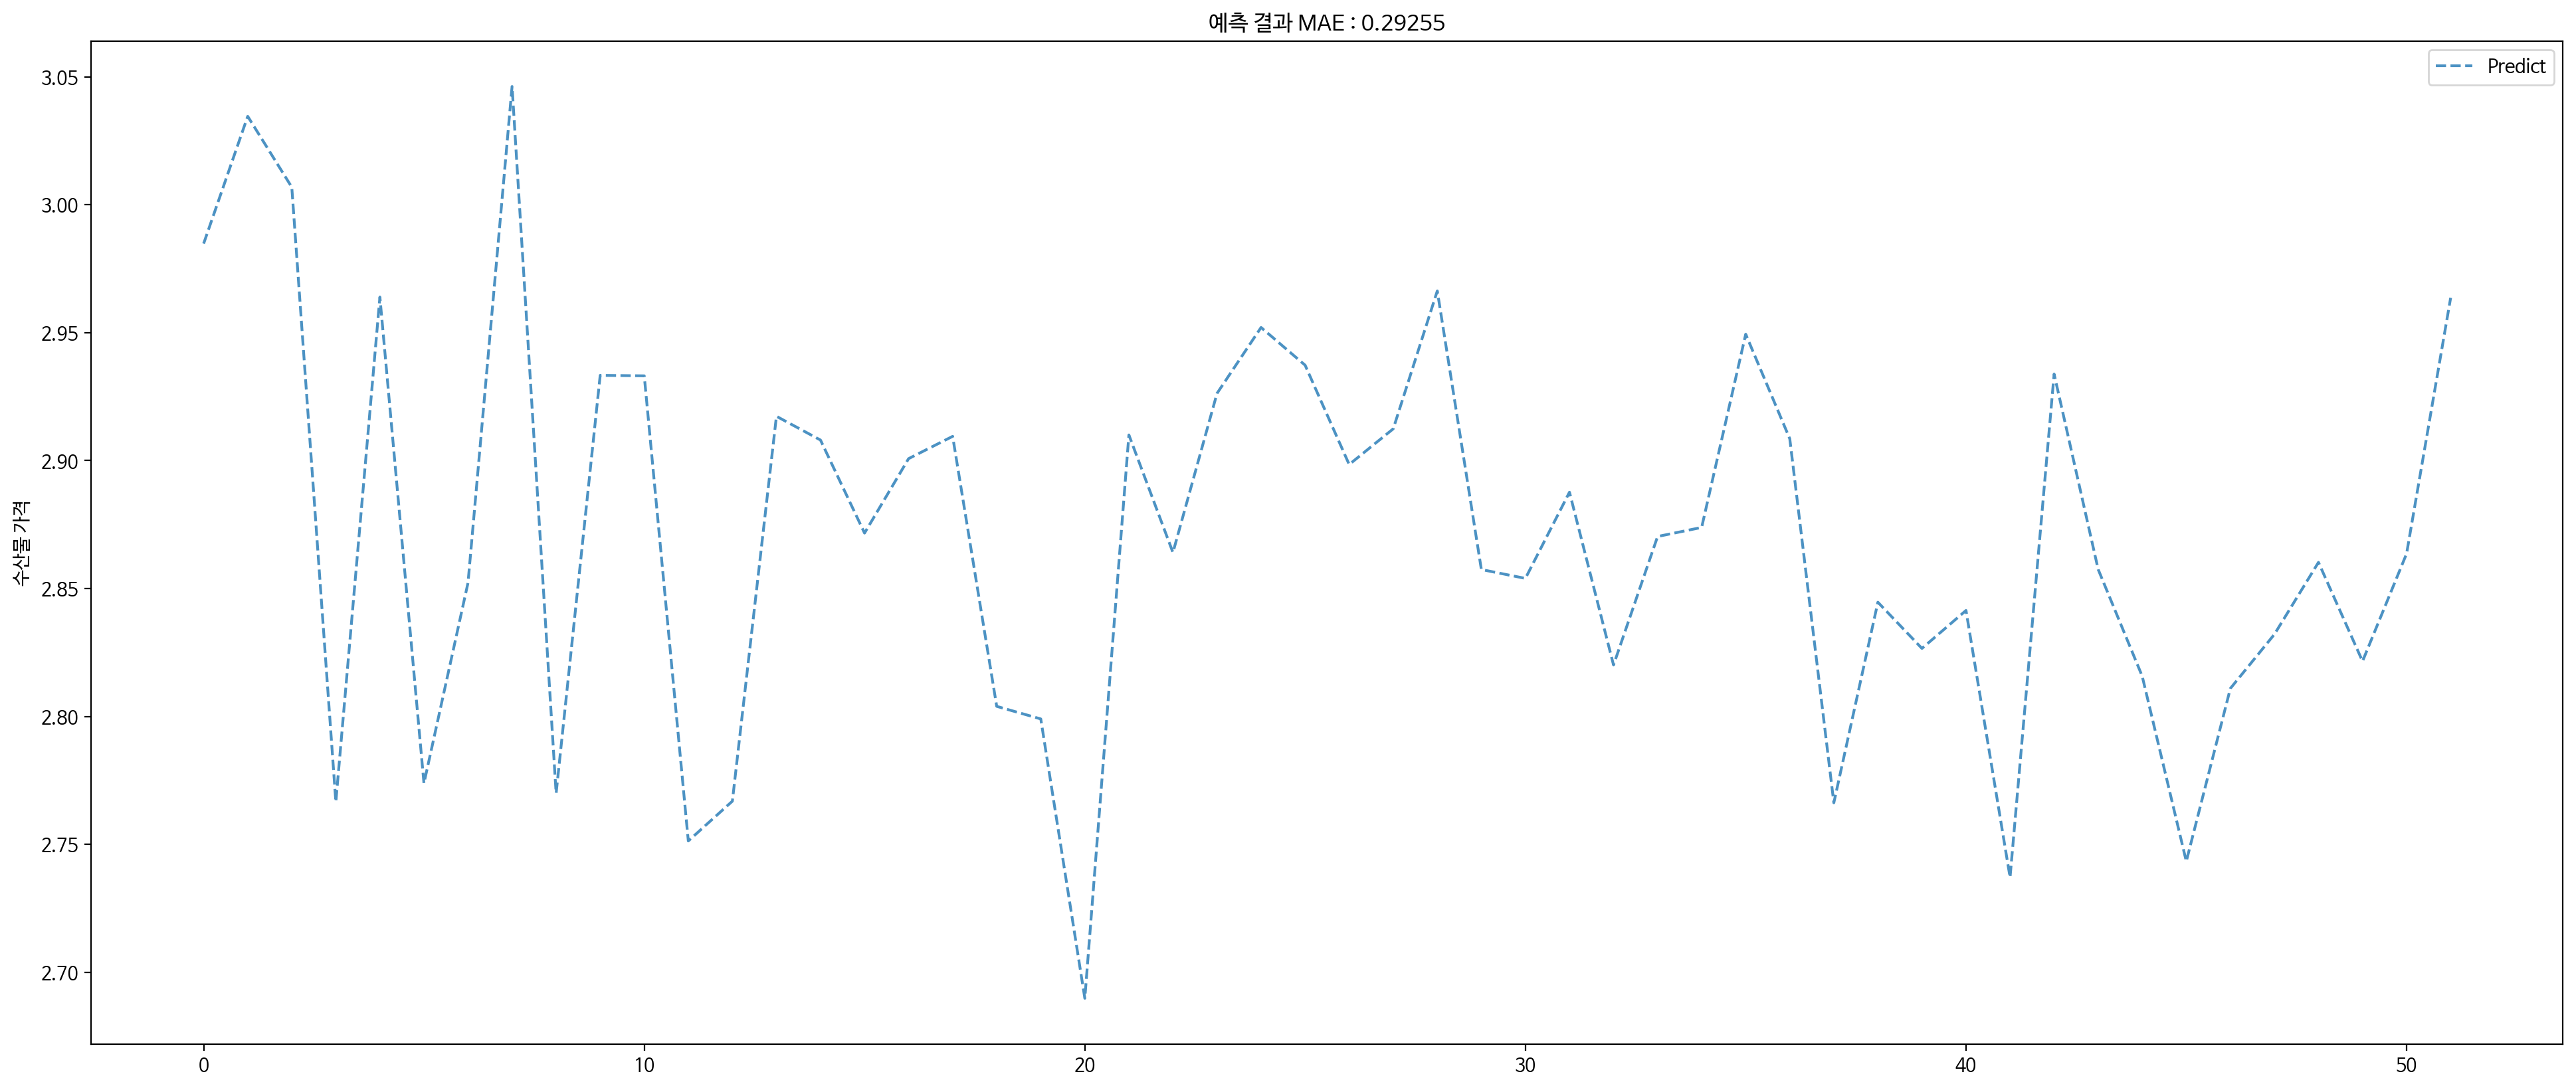

In [35]:
X = df_squid_predict[['CTRY_1',	'CTRY_2',	'P_PURPOSE', 'P_IMPORT_TYPE',	'P_PRICE']].values.reshape(-1,1,5)
y = df_squid20['P_PRICE']
y_pred = model.predict(X)

MAE = mean_absolute_error(y, y_pred.reshape(-1, 1))

plt.figure(figsize=(24, 10),dpi=200)
plt.title('예측 결과'+   ' MAE : ' + str(MAE)[:7])
plt.ylabel('수산물 가격')
plt.plot(y_pred.reshape(-1, 1), alpha = 0.8,linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

## 오징어 가격 예측 정답
- 20년도 데이터를 input하여 21년도 오징어 가격을 산출하여 최종 답안으로 제출

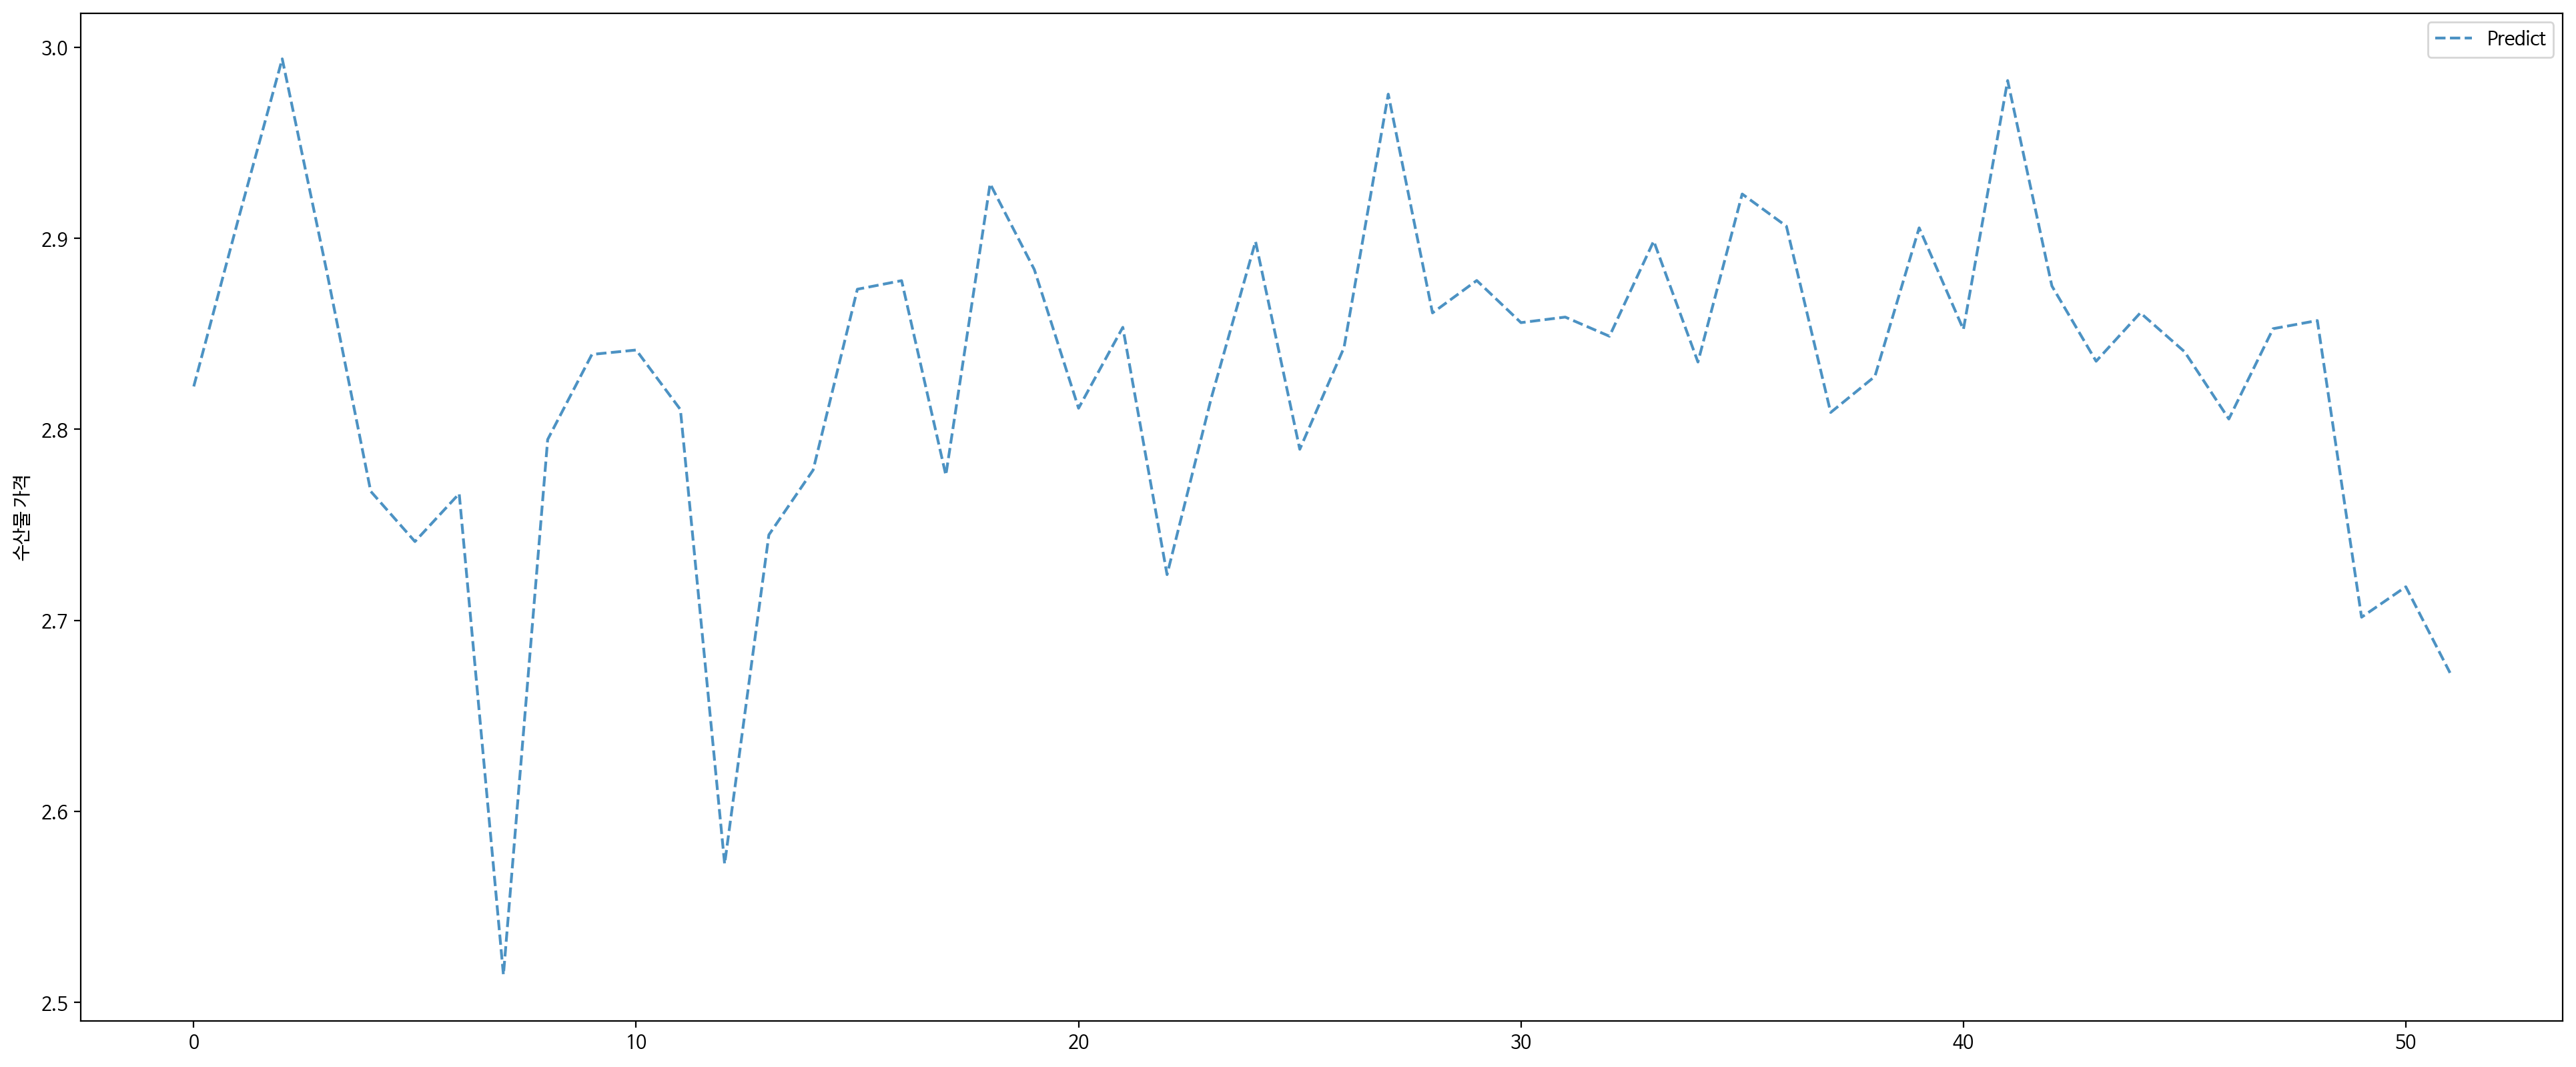

In [36]:
X = df_squid20[['CTRY_1',	'CTRY_2',	'P_PURPOSE', 'P_IMPORT_TYPE',	'P_PRICE']].values.reshape(-1,1,5)
y_pred = model.predict(X)

plt.figure(figsize=(24, 10),dpi=200)
plt.ylabel('수산물 가격')
plt.plot(y_pred.reshape(-1, 1), alpha = 0.8,linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

- 2021년 6달의 오징어 가격 정답

In [37]:
y_pred[:26]

array([[2.8224823],
       [2.9093792],
       [2.9939702],
       [2.8834286],
       [2.7675796],
       [2.7412832],
       [2.7663634],
       [2.514451 ],
       [2.7946997],
       [2.839246 ],
       [2.841552 ],
       [2.8103914],
       [2.5725079],
       [2.7448063],
       [2.7787008],
       [2.873365 ],
       [2.8778632],
       [2.776028 ],
       [2.928577 ],
       [2.8836808],
       [2.8110769],
       [2.8534296],
       [2.723968 ],
       [2.8164475],
       [2.8983862],
       [2.7895858]], dtype=float32)

# 연어 가격 예측

## 데이터프레임에서 연어만 추출 후 이상치 제거 및 전처리
이상치 제거에는 IQR 방식을 사용함 이상치를 제거해도 된다고 판단한 이유는 미래에는 천재지변으로 인한 수산물 가격의 급등 혹은 급락이 없을 것이라고 가정한 후에 예측을 진행할 것이기 때문에 제거하기로 결정<br><br>
- 각 년도 별로 데이터가 수집된 일자가 다르기 때문에 월 별로 Week_Number(1년중 몇번째 주차인지)를 기준으로 데이터를 정렬해야 함
- 제공된 데이터 중 16년부터 19년의 데이터를 활용할 것이고 또한 2015년인 데이터는 오직 12월 28일의 데이터만 있기 때문에 활용하지 않으므로 제거해줌
- 년도 별로 수집된 데이터의 시작 요일이 다르므로 구분하여서 Week_Number을 산출하였음 ex) 16년과 17년의 데이터의 수집시작 요일은 일요일이나 18년과 19년의 데이터의 수집시작 요일은 월요일임

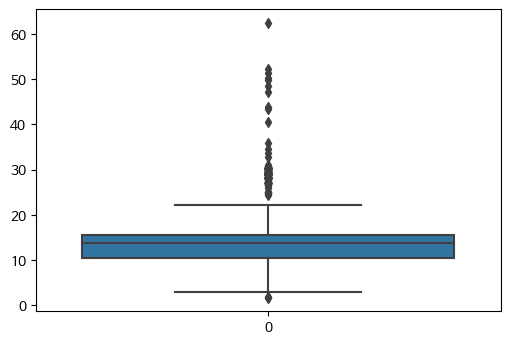

In [38]:
df_salmon = df[df['P_NAME'] == '연어'].drop('CATEGORY_1', axis=1)

# 연어 가격의 boxplot을 통한 데이터 탐색
plt.figure(dpi=100)
sns.boxplot(data=df_salmon['P_PRICE'].values)
plt.show()

In [39]:
quantile_25 = np.percentile(df_salmon['P_PRICE'].values, 25)
quantile_75 = np.percentile(df_salmon['P_PRICE'].values, 75)
weight = 1.5

IQR = quantile_75 - quantile_25
IQR_weight = IQR*weight
  
lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight
  
outlier_idx = df_salmon['P_PRICE'][ (df_salmon['P_PRICE'] < lowest) | (df_salmon['P_PRICE'] > highest) ].index

df_salmon.drop(outlier_idx, axis=0, inplace=True)
df_salmon.reset_index(drop=True,inplace=True)

df_salmon = df_salmon[df_salmon['REG_DATE'] != '2015-12-28']

df_salmon['YEAR'] = pd.to_datetime(df_salmon.REG_DATE).dt.year
df_salmon['MONTH'] = pd.to_datetime(df_salmon.REG_DATE).dt.month
df_salmon16 = df_salmon[df_salmon['YEAR']== 2016]
df_salmon17 = df_salmon[df_salmon['YEAR']== 2017]
df_salmon18 = df_salmon[df_salmon['YEAR']== 2018]
df_salmon19 = df_salmon[df_salmon['YEAR']== 2019]
df_salmon16['Week_Number'] = df_salmon16['REG_DATE'].dt.strftime('%U').astype(int)
df_salmon17['Week_Number'] = df_salmon17['REG_DATE'].dt.strftime('%U').astype(int)
df_salmon18['Week_Number'] = df_salmon18['REG_DATE'].dt.strftime('%W').astype(int)
df_salmon19['Week_Number'] = df_salmon19['REG_DATE'].dt.strftime('%W').astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

- 연어의 각 년도 별로 추세를 확인하기 위해 그래프를 그려봄 연어에는 계절적인 추세가 있다고 판단함

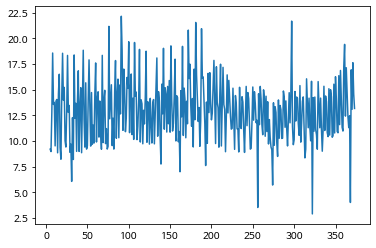

In [40]:
plt.plot(df_salmon16['P_PRICE'])
plt.show()

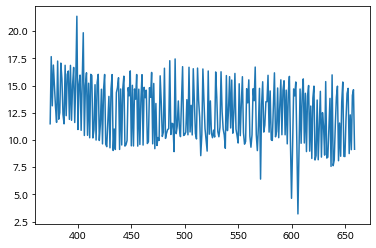

In [41]:
plt.plot(df_salmon17['P_PRICE'])
plt.show()

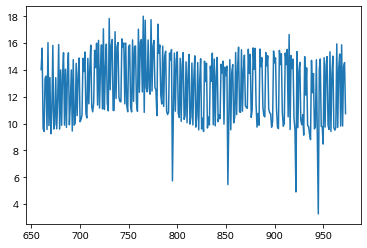

In [42]:
plt.plot(df_salmon18['P_PRICE'])
plt.show()

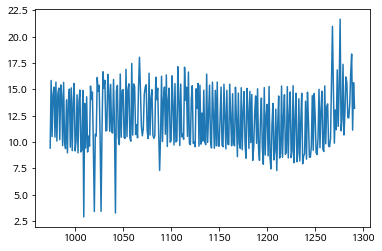

In [43]:
plt.plot(df_salmon19['P_PRICE'])
plt.show()

In [44]:
df_salmon = pd.concat([df_salmon16,df_salmon17,df_salmon18,df_salmon19])
df_salmon = df_salmon.reset_index(drop=True)

- 2018년도의 데이터만 53주차가 있으므로 53주차인 데이터를 제거(52주 기준으로 정렬하기 위함)
- 컬럼에서 Identifier가 아닌 CATEGORY_2, P_NAME, MONTH를 제거

In [45]:
df_salmon = df_salmon[['YEAR','MONTH','Week_Number','CTRY_1',"CTRY_2","CATEGORY_2"	,"P_NAME"	,	"P_PURPOSE",	"P_IMPORT_TYPE",	"P_PRICE"]]
df_salmon = df_salmon[df_salmon['Week_Number'] != 53]
df_salmon = df_salmon.drop(['CATEGORY_2', 'P_NAME', 'MONTH'], axis=1)
df_salmon

YEAR  Week_Number CTRY_1 CTRY_2 P_PURPOSE  P_IMPORT_TYPE    P_PRICE
0     2016            1    캐나다    캐나다       판매용             냉장   9.200743
1     2016            1   노르웨이   노르웨이   자사제품제조용             냉장   8.966241
2     2016            1   노르웨이   노르웨이       판매용       냉장,필렛(F)  12.736953
3     2016            1   노르웨이   노르웨이       판매용  냉장,포장횟감,필렛(F)  18.577778
4     2016            1   노르웨이   노르웨이       판매용    냉장,필렛(F),횟감  13.562398
...    ...          ...    ...    ...       ...            ...        ...
1282  2019           52   노르웨이   노르웨이       판매용       냉장,필렛(F)  16.495971
1283  2019           52   노르웨이   노르웨이       판매용    냉장,필렛(F),횟감  18.350634
1284  2019           52   노르웨이   노르웨이   자사제품제조용             냉장  11.128269
1285  2019           52   노르웨이   노르웨이   자사제품제조용       냉장,필렛(F)  15.631531
1286  2019           52   노르웨이   노르웨이       판매용             냉장  13.205675

[1282 rows x 7 columns]

## 라벨인코딩 작업
데이터프레임에서 가격을 예측하는 데 활용할 수 있는 feature가 모두 범주형 데이터(자연어)이므로 모델에 활용하기 위해 정수인코딩을 해주어야 함<br><br>
- df_salmon에서 범주형 컬럼들의 값을 모두 text라는 하나의 공간에 담아서 단어를 토큰화 해준 뒤 1번 밖에 나타나지 않은 단어는 제거해주었음

In [46]:
text = df_salmon[['CTRY_1',	'CTRY_2', 'P_PURPOSE',	'P_IMPORT_TYPE']].values
text[0]

array(['캐나다', '캐나다', '판매용', '냉장'], dtype=object)

In [47]:
vocab = {} # 파이썬의 dictionary 자료형
sentences = []

for i in text:
    sentence = i # 단어 토큰화를 수행합니다.
    result = []

    for word in sentence: 
        if len(word) > 0: # 단어 길이가 2이하인 경우에 대하여 추가로 단어를 제거합니다.
            result.append(word)
            if word not in vocab:
                vocab[word] = 0 
            vocab[word] += 1
    sentences.append(result) 
sentences[0]

['캐나다', '캐나다', '판매용', '냉장']

- vocab은 중복을 제거한 단어와 각 단어에 대한 빈도수가 기록되어져 있음<br>
Key(단어) : Value(각 단어에 대한 빈도수)로 이루어진 dictionary임

In [48]:
vocab

{'냉동': 14,
 '냉동,곤이': 1,
 '냉동,슬라이스(S),포장횟감': 2,
 '냉동,필렛(F)': 1,
 '냉장': 598,
 '냉장,포장횟감,필렛(F)': 29,
 '냉장,필렛(F)': 403,
 '냉장,필렛(F),횟감': 234,
 '노르웨이': 2153,
 '러시아': 18,
 '미국': 9,
 '베트남': 3,
 '아이슬란드': 6,
 '아일랜드': 4,
 '영국': 240,
 '외화획득용 원료': 8,
 '자사제품제조용': 438,
 '중국': 1,
 '칠레': 4,
 '캐나다': 102,
 '판매용': 836,
 '호주': 24}

- vocab에서 빈도 수가 높은 순서대로 정렬을 진행

In [49]:
vocab_sorted = sorted(vocab.items(), key = lambda x:x[1], reverse = True)

- 높은 빈도 수를 가진 단어일수록 낮은 정수 인덱스를 부여함 또한 빈도 수가 1인 단어들은 제거

In [50]:
word_to_index = {}
i=0
for (word, frequency) in vocab_sorted :
    if frequency > 1 :
        i=i+1
        word_to_index[word] = i
word_to_index

{'냉동': 12,
 '냉동,슬라이스(S),포장횟감': 19,
 '냉장': 3,
 '냉장,포장횟감,필렛(F)': 9,
 '냉장,필렛(F)': 5,
 '냉장,필렛(F),횟감': 7,
 '노르웨이': 1,
 '러시아': 11,
 '미국': 13,
 '베트남': 18,
 '아이슬란드': 15,
 '아일랜드': 17,
 '영국': 6,
 '외화획득용 원료': 14,
 '자사제품제조용': 4,
 '칠레': 16,
 '캐나다': 8,
 '판매용': 2,
 '호주': 10}

- vocab에 존재하지 않는 단어들을 Out Of Vocabulary(OOV)라는 단어로 새롭게 추가하고, vocab에 없는 단어들을 OOV의 인덱스로 인코딩 함

In [51]:
word_to_index['OOV'] = len(word_to_index) + 1

- word_to_index를 사용하여 sentences의 모든 단어들을 맵핑되는 정수로 인코딩 후에 인코딩 된 값들로 df의 범주형 값들을 교체해 주었음

In [52]:
encoded = []
for s in sentences:
    temp = []
    for w in s:
        try:
            temp.append(word_to_index[w])
        except KeyError:
            temp.append(word_to_index['OOV'])
    encoded.append(temp)
encoded[0]

[8, 8, 2, 3]

In [53]:
df_salmon[['CTRY_1',	'CTRY_2', 'P_PURPOSE',	'P_IMPORT_TYPE']] = encoded
df_salmon

YEAR  Week_Number  CTRY_1  CTRY_2  P_PURPOSE  P_IMPORT_TYPE    P_PRICE
0     2016            1       8       8          2              3   9.200743
1     2016            1       1       1          4              3   8.966241
2     2016            1       1       1          2              5  12.736953
3     2016            1       1       1          2              9  18.577778
4     2016            1       1       1          2              7  13.562398
...    ...          ...     ...     ...        ...            ...        ...
1282  2019           52       1       1          2              5  16.495971
1283  2019           52       1       1          2              7  18.350634
1284  2019           52       1       1          4              3  11.128269
1285  2019           52       1       1          4              5  15.631531
1286  2019           52       1       1          2              3  13.205675

[1282 rows x 7 columns]

- YEAR와 Week_Number로 groupby를 진행 한 뒤 각 주차별로 평균을 산출하였음 빈도 수를 기준으로 인코딩 된 값들의 평균과 각 주차별로 평균으로 이루어진 값으로 df_salmon을 재정의

In [54]:
df_salmon = df_salmon.groupby(['YEAR', 'Week_Number']).mean()

## 모델링
모델은 지난 1년 간의 데이터로 1년 후를 예측하는 모델이므로 Target은 1년 후의 실제 가격임


In [55]:
df_salmon['P_PRICE'].shift(-52)

YEAR  Week_Number
2016  1              14.263302
      2              14.132933
      3              14.397631
      4              14.966864
      5              14.524451
      6              13.505485
      7              12.871019
      8              12.668092
      9              11.997391
      10             12.349325
      11             12.846680
      12             12.355769
      13             13.053550
      14             12.713049
      15             13.237149
      16             12.880430
      17             11.804166
      18             11.972510
      19             11.803822
      20             12.359234
      21             12.145012
      22             12.324811
      23             12.459066
      24             12.890241
      25             13.099933
      26             12.037093
      27             11.677594
      28             12.051229
      29             12.262639
      30             12.299853
      31             13.140877
      32             

In [56]:
df_salmon['Target'] = df_salmon['P_PRICE'].shift(-52)
df_salmon

CTRY_1    CTRY_2  P_PURPOSE  P_IMPORT_TYPE    P_PRICE  \
YEAR Week_Number                                                            
2016 1            2.000000  2.000000   2.571429       5.000000  12.331994   
     2            1.000000  1.000000   2.666667       5.333333  12.876513   
     3            1.000000  1.000000   2.666667       5.333333  13.387350   
     4            1.000000  1.000000   2.666667       6.000000  12.644323   
     5            1.875000  1.875000   2.750000       5.250000  11.185117   
     6            1.000000  1.000000   2.666667       5.333333  12.859437   
     7            1.000000  1.000000   2.666667       5.333333  13.171931   
     8            2.000000  2.000000   2.571429       5.000000  12.669716   
     9            1.875000  1.875000   2.750000       5.250000  12.835547   
     10           1.875000  1.875000   2.750000       5.250000  12.639193   
     11           1.875000  1.875000   2.750000       5.250000  12.757672   
     12           1.875000  1.875000   2.750000       5.250000  13.147584   
     13           1.875000  1.875000   2.750000       5.250000  15.381007   
     14           1.875000  1.875000   2.750000       5.250000  14.511156   
     15           1.000000  1.000000   2.666667       5.333333  13.864540   
     16           1.000000  1.000000   2.857143       5.571429  13.075083   
     17           1.875000  1.875000   2.750000       5.250000  13.079364   
     18           1.000000  1.000000   3.000000       5.000000  12.180897   
     19           1.000000  1.000000   2.857143       5.571429  13.593951   
     20           1.625000  1.625000   2.750000       5.250000  13.345613   
     21           1.000000  1.000000   2.857143       5.571429  13.986294   
     22           1.000000  1.000000   2.857143       5.571429  13.233300   
     23           2.333333  2.333333   2.666667       5.000000  12.716718   
     24           1.000000  1.000000   2.857143       5.571429  14.977080   
     25           1.875000  1.875000   2.750000       5.250000  14.585431   
     26           1.875000  1.875000   2.750000       5.250000  14.198280   
     27           2.500000  2.500000   2.750000       4.500000  12.867770   
     28           2.500000  2.500000   2.750000       4.500000  14.189692   
     29           2.500000  2.500000   2.750000       4.500000  13.485402   
     30           1.714286  1.714286   2.857143       4.714286  13.273919   
     31           3.750000  3.750000   2.750000       4.500000  12.244107   
     32           3.875000  3.875000   2.750000       4.500000  12.142827   
     33           1.714286  1.714286   2.857143       4.714286  12.647294   
     34           2.500000  2.500000   2.750000       4.500000  12.230169   
     35           2.714286  2.714286   2.857143       6.000000  11.819257   
     36           1.000000  1.000000   3.000000       5.000000  12.579168   
     37           1.000000  1.000000   3.000000       4.000000  11.493477   
     38           4.000000  4.000000   2.500000       5.125000  10.435317   
     39           1.833333  1.833333   2.666667       4.333333  11.586584   
     40           2.166667  2.166667   2.666667       4.333333  12.644466   
     41           4.000000  4.000000   2.571429       4.142857  13.704831   
     42           2.714286  2.714286   2.571429       4.142857  12.390249   
     43           2.714286  2.714286   2.571429       4.142857  12.452981   
     44           2.714286  2.714286   2.571429       4.142857  12.031038   
     45           3.142857  3.142857   4.285714       5.428571  11.330117   
     46           2.714286  2.714286   2.571429       4.142857  12.269806   
     47           2.714286  2.714286   2.571429       4.142857  12.206199   
     48           2.166667  2.166667   2.666667       4.333333  12.630499   
     49           2.166667  2.166667   2.666667       4.333333  13.017943   
     50           2.166667  2.166667   2.666667       4.333333  13.524848   
     51         

- 16,17,18년 데이터로 각각 1년 후를 예측하는 모델을 만들고 그 모델에 19년도의 데이터를 넣어서 20년을 예측

In [57]:
df_salmon_learn = df_salmon[df_salmon['Target'].notnull()]
df_salmon_predict = df_salmon[df_salmon['Target'].isnull()]
X = df_salmon_learn[['CTRY_1',	'CTRY_2',	'P_PURPOSE', 'P_IMPORT_TYPE',	'P_PRICE']].values.reshape(-1,1,5)
y = df_salmon_learn['Target'].values.reshape(-1,1,1)

- 가격은 모두 달러로 나타나며 예측하려는 값도 동일한 단위이므로 스케일링을 진행하지 않았음<br>
시계열적 특성을 반영하기 위해서 LSTM 모델을 사용하였고 계절적 추세를 반영하기 위해 Input_shape는 행(12주)3달,열(Feature 갯수=5개)로 투입하였음


In [58]:
with tf.device('/device:GPU:0'):
  model = Sequential()
  model.add(layers.LSTM(100, input_shape=(12,5), activation='relu'))
  model.add(layers.Dense(30))
  model.add(layers.Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.fit(X, y, epochs=1000, batch_size=50)

  # model.save("salmon.h5")
  model = tf.keras.models.load_model("/content/gdrive/MyDrive/data/salmon.h5")

Epoch 1/1000
4/4 [==============================] - 1s 10ms/step - loss: 146.8362
Epoch 2/1000
4/4 [==============================] - 0s 8ms/step - loss: 134.9094
Epoch 3/1000
4/4 [==============================] - 0s 7ms/step - loss: 122.1353
Epoch 4/1000
4/4 [==============================] - 0s 8ms/step - loss: 107.5756
Epoch 5/1000
4/4 [==============================] - 0s 8ms/step - loss: 90.5436
Epoch 6/1000
4/4 [==============================] - 0s 9ms/step - loss: 71.0513
Epoch 7/1000
4/4 [==============================] - 0s 8ms/step - loss: 49.7554
Epoch 8/1000
4/4 [==============================] - 0s 8ms/step - loss: 28.8601
Epoch 9/1000
4/4 [==============================] - 0s 10ms/step - loss: 11.6758
Epoch 10/1000
4/4 [==============================] - 0s 10ms/step - loss: 2.9537
Epoch 11/1000
4/4 [==============================] - 0s 8ms/step - loss: 3.7214
Epoch 12/1000
4/4 [==============================] - 0s 10ms/step - loss: 6.7975
Epoch 13/1000
4/4 [=============

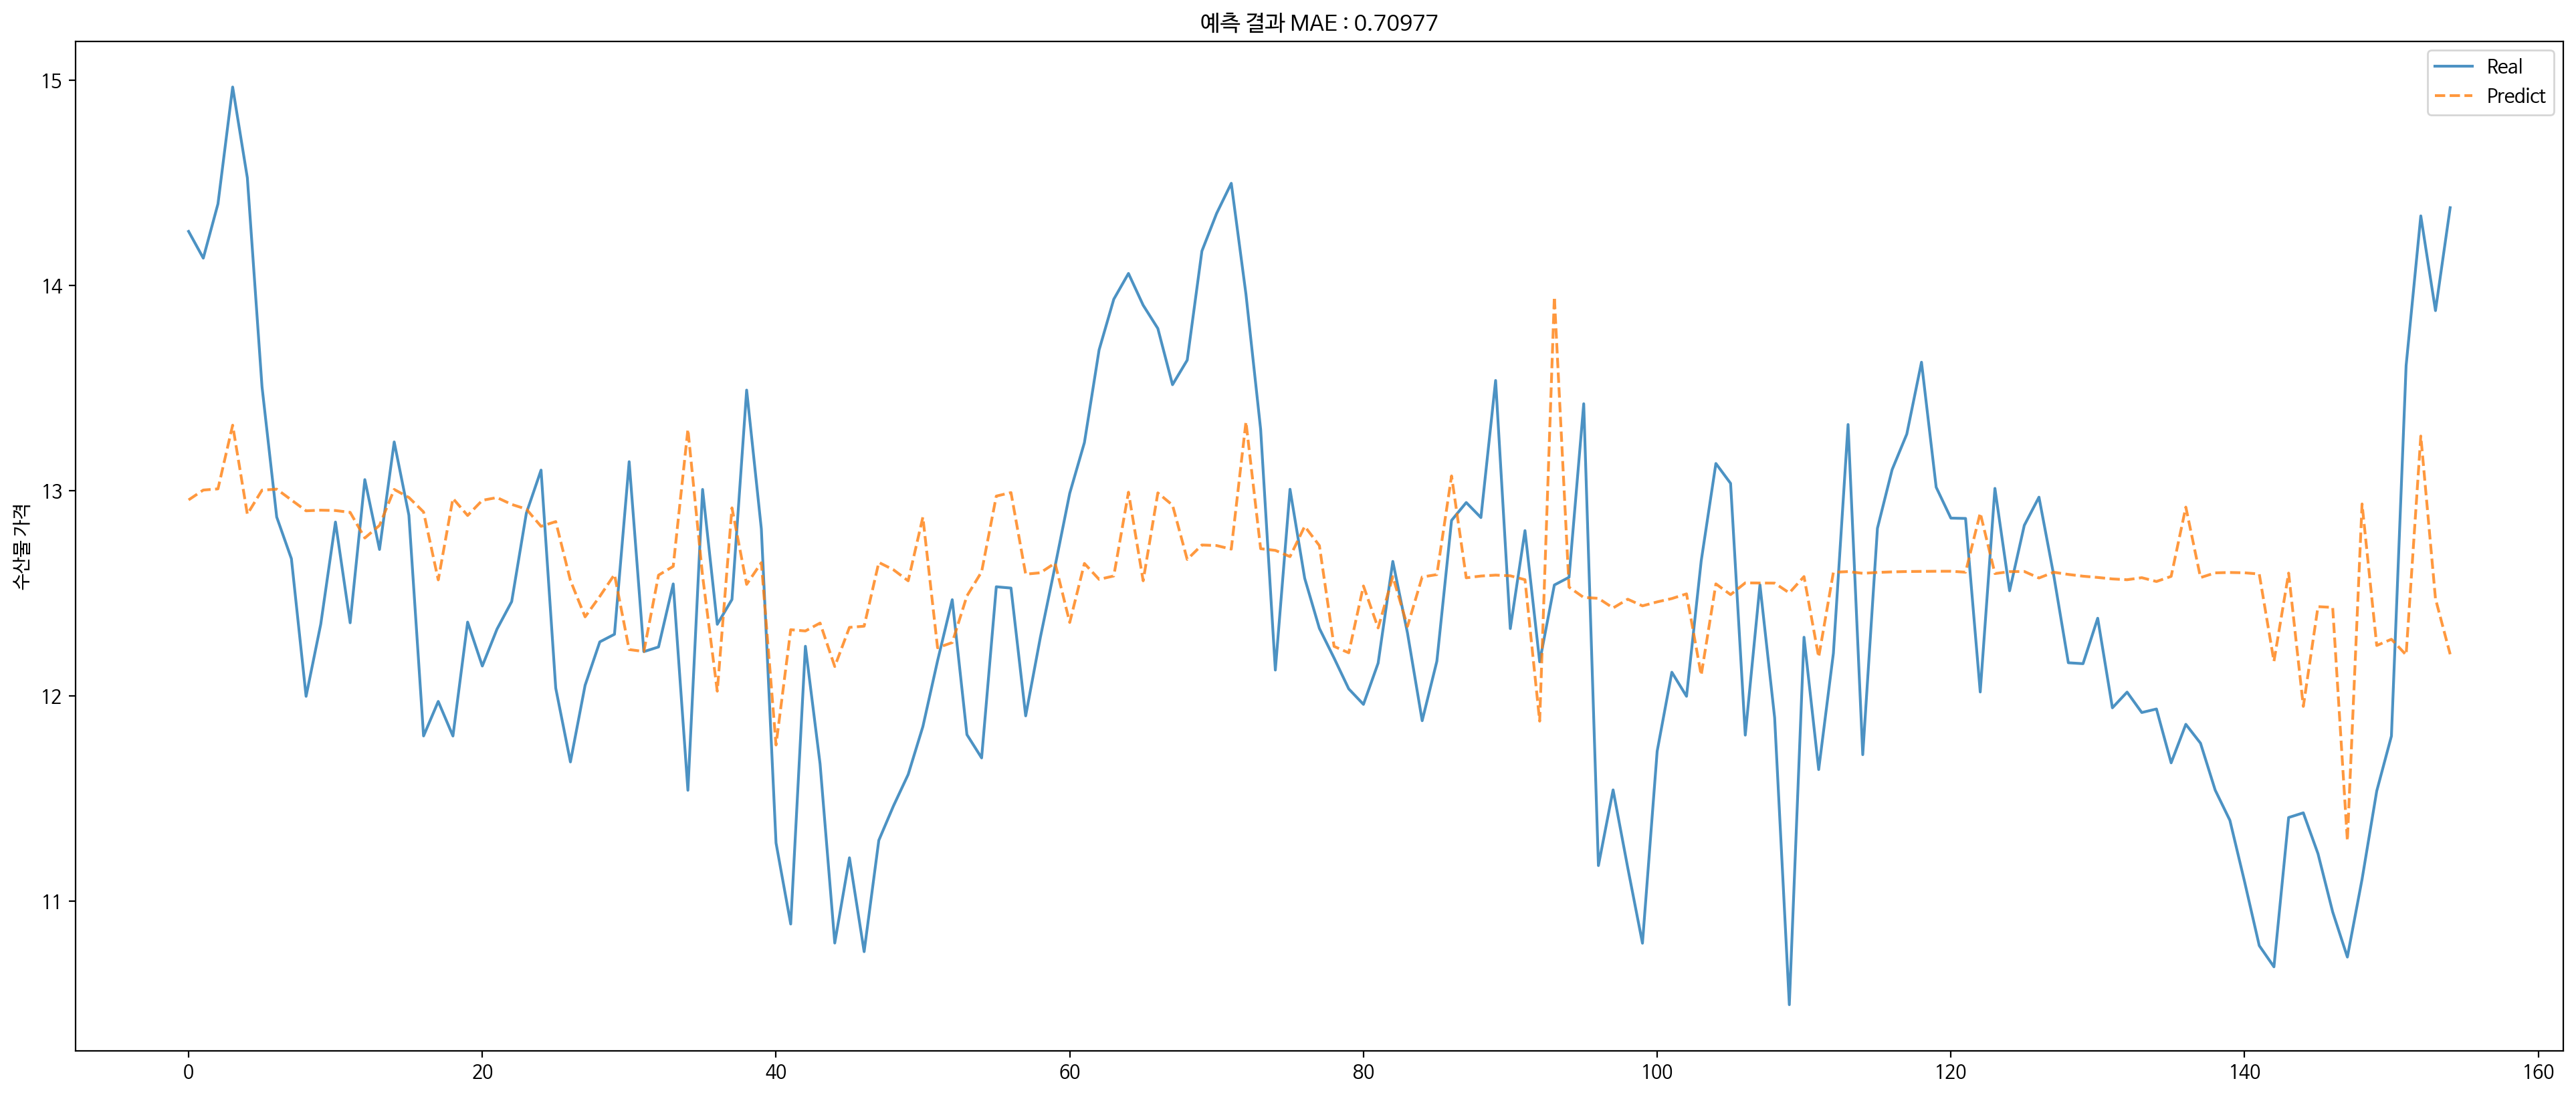

In [59]:
y_pred = model.predict(X)


MAE = mean_absolute_error(y.reshape(-1,1), y_pred.reshape(-1, 1))

plt.figure(figsize=(24, 10),dpi=200)
plt.title('예측 결과'+   ' MAE : ' + str(MAE)[:7])
plt.ylabel('수산물 가격')
plt.plot(np.array(y).reshape(-1,1), alpha = 0.8, label = 'Real')
plt.plot(y_pred.reshape(-1, 1), alpha = 0.8,linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

## Input데이터인 20년도 데이터프레임 정의 및 전처리

- 20년도 데이터에서 연어어만을 추출하여 이상치를 IQR로 제거하고 주차별로 정렬하기 위한 전처리 작업 수행

In [60]:
df_salmon20 = df20[df20['P_NAME'] == '연어'].drop('CATEGORY_1', axis=1)

quantile_25 = np.percentile(df_salmon20['P_PRICE'].values, 25)
quantile_75 = np.percentile(df_salmon20['P_PRICE'].values, 75)
weight = 1.5

IQR = quantile_75 - quantile_25
IQR_weight = IQR*weight
  
lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight
  
outlier_idx = df_salmon20['P_PRICE'][ (df_salmon20['P_PRICE'] < lowest) | (df_salmon20['P_PRICE'] > highest) ].index

df_salmon20.drop(outlier_idx, axis=0, inplace=True)
df_salmon20.reset_index(drop=True,inplace=True)

df_salmon20['YEAR'] = pd.to_datetime(df_salmon20.REG_DATE).dt.year
df_salmon20['MONTH'] = pd.to_datetime(df_salmon20.REG_DATE).dt.month

df_salmon20['Week_Number'] = df_salmon20['REG_DATE'].dt.strftime('%U').astype(int)


In [61]:
df_salmon20 = df_salmon20[['YEAR','MONTH','Week_Number','CTRY_1',"CTRY_2","CATEGORY_2"	,"P_NAME"	,	"P_PURPOSE",	"P_IMPORT_TYPE",	"P_PRICE"]]
df_salmon20 = df_salmon20.drop(['CATEGORY_2', 'P_NAME', 'MONTH'], axis=1)
df_salmon20

YEAR  Week_Number CTRY_1 CTRY_2 P_PURPOSE P_IMPORT_TYPE    P_PRICE
0    2020            1     영국     영국       판매용            냉장  13.710029
1    2020            1   노르웨이   노르웨이   자사제품제조용            냉장  12.199457
2    2020            1   노르웨이   노르웨이       판매용      냉장,필렛(F)  16.335035
3    2020            1   노르웨이   노르웨이   자사제품제조용      냉장,필렛(F)  14.756580
4    2020            1   노르웨이   노르웨이       판매용            냉장  13.170679
..    ...          ...    ...    ...       ...           ...        ...
352  2020           52   노르웨이   노르웨이       판매용   냉장,필렛(F),횟감  14.620000
353  2020           52   노르웨이   노르웨이   자사제품제조용            냉장   8.750000
354  2020           52   노르웨이   노르웨이       판매용      냉장,필렛(F)  15.290000
355  2020           52   노르웨이   노르웨이   자사제품제조용      냉장,필렛(F)  14.260000
356  2020           52   노르웨이   노르웨이       판매용            냉장   8.590000

[357 rows x 7 columns]

- 20년도 연어 가격의 추세 확인을 위한 그래프를 그렸으며 동일하게 계절적 추세성이 있다고 판단

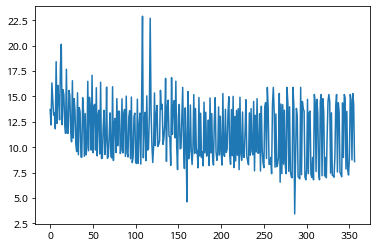

In [62]:
plt.plot(df_salmon20['P_PRICE'])
plt.show()

- 위에서 인코딩한 데이터를 끌어와서 빈도 수 기준으로 동일하게 인코딩 후 범주형 데이터 재정의

In [63]:
text = df_salmon20[['CTRY_1',	'CTRY_2', 'P_PURPOSE',	'P_IMPORT_TYPE']].values
text[0]

array(['영국', '영국', '판매용', '냉장'], dtype=object)

In [64]:
sentences = []

for i in text:
    sentence = i # 단어 토큰화를 수행합니다.
    result = []

    for word in sentence: 
        if len(word) > 0: # 단어 길이가 2이하인 경우에 대하여 추가로 단어를 제거합니다.
            result.append(word)            
    sentences.append(result) 
sentences[0]

['영국', '영국', '판매용', '냉장']

In [65]:
encoded = []
for s in sentences:
    temp = []
    for w in s:
        try:
            temp.append(word_to_index[w])
        except KeyError:
            temp.append(word_to_index['OOV'])
    encoded.append(temp)
encoded[0]

[6, 6, 2, 3]

In [66]:
df_salmon20[['CTRY_1',	'CTRY_2', 'P_PURPOSE',	'P_IMPORT_TYPE']] = encoded
df_salmon20

YEAR  Week_Number  CTRY_1  CTRY_2  P_PURPOSE  P_IMPORT_TYPE    P_PRICE
0    2020            1       6       6          2              3  13.710029
1    2020            1       1       1          4              3  12.199457
2    2020            1       1       1          2              5  16.335035
3    2020            1       1       1          4              5  14.756580
4    2020            1       1       1          2              3  13.170679
..    ...          ...     ...     ...        ...            ...        ...
352  2020           52       1       1          2              7  14.620000
353  2020           52       1       1          4              3   8.750000
354  2020           52       1       1          2              5  15.290000
355  2020           52       1       1          4              5  14.260000
356  2020           52       1       1          2              3   8.590000

[357 rows x 7 columns]

- Year와 Week_Number로 groupby한 평균 값으로 df_salmon20을 재정의

In [67]:
df_salmon20 = df_salmon20.groupby(['YEAR', 'Week_Number']).mean()
df_salmon20

CTRY_1    CTRY_2  P_PURPOSE  P_IMPORT_TYPE    P_PRICE
YEAR Week_Number                                                         
2020 1            2.000000  2.000000   2.800000       3.800000  14.034356
     2            3.714286  3.714286   2.571429       4.142857  14.211810
     3            1.000000  1.000000   2.666667       5.333333  15.587532
     4            3.714286  3.714286   2.571429       4.142857  13.467106
     5            1.833333  1.833333   2.666667       4.333333  12.787795
     6            3.500000  3.500000   2.666667       7.166667  11.773359
     7            3.333333  3.333333   2.666667       4.333333  11.510497
     8            3.333333  3.333333   2.666667       4.333333  12.427460
     9            1.000000  1.000000   2.800000       4.600000  12.905506
     10           1.000000  1.000000   2.800000       4.600000  12.231819
     11           2.166667  2.166667   2.666667       4.333333  11.505838
     12           2.714286  2.714286   2.571429       4.142857  11.184095
     13           2.166667  2.166667   2.666667       4.333333  11.394656
     14           1.000000  1.000000   2.800000       4.600000  12.283304
     15           1.833333  1.833333   2.666667       4.333333  11.658406
     16           1.833333  1.833333   2.666667       4.333333  11.497561
     17           1.833333  1.833333   2.666667       4.333333  11.213304
     18           1.833333  1.833333   2.666667       4.333333  10.890206
     19           1.000000  1.000000   2.666667       5.333333  13.567672
     20           1.714286  1.714286   2.571429       5.000000  13.489495
     21           2.714286  2.714286   2.571429       4.142857  11.654049
     22           1.833333  1.833333   2.666667       4.333333  12.467153
     23           2.714286  2.714286   2.571429       4.142857  12.596234
     24           2.714286  2.714286   2.571429       4.142857  12.402586
     25           2.166667  2.166667   2.666667       4.333333  11.912271
     26           2.714286  2.714286   2.571429       4.142857  11.527250
     27           4.166667  4.166667   2.666667       5.500000  10.400527
     28           3.000000  3.000000   2.666667       4.000000  11.021872
     29           3.000000  3.000000   2.666667       4.000000  10.674134
     30           3.000000  3.000000   2.666667       4.000000  10.698689
     31           2.714286  2.714286   2.571429       4.142857  10.995377
     32           4.375000  4.375000   2.500000       4.000000  10.827124
     33           4.375000  4.375000   2.500000       4.000000  10.978263
     34           3.857143  3.857143   2.571429       4.142857  11.248288
     35           3.500000  3.500000   2.666667       4.333333  11.258470
     36           3.857143  3.857143   2.571429       4.142857  11.021626
     37           4.625000  4.625000   2.500000       4.000000  10.492770
     38           3.857143  3.857143   2.571429       4.142857  11.081210
     39           3.857143  3.857143   2.571429       4.142857  11.205306
     40           4.000000  4.000000   2.750000       4.750000  11.476810
     41           4.666667  4.666667   2.888889       4.555556  10.860084
     42           5.500000  6.200000   2.800000       6.100000  10.517739
     43           3.500000  3.500000   2.666667       5.000000  11.157626
     44           4.333333  4.333333   4.888889       5.555556  10.007100
     45           4.000000  4.000000   2.750000       4.750000  10.757969
     46           4.428571  4.428571   2.571429       4.142857  10.138422
     47           4.666667  4.666667   2.888889       4.555556  10.615930
     48           3.142857  3.142857   2.857143       5.000000  11.294710
     49           4.222222  4.222222   2.888889       4.555556  11.058546
     50           4.666667  4.666667   2.888889       4.555556  10.594668
     51           4.666667  4.666667   2.888889       4.555556  10.785036
     52           3.250000  3.250000   3.000000       4.750000  11.622500

- 19년도 데이터를 이용하여 20년도 가격을 예측

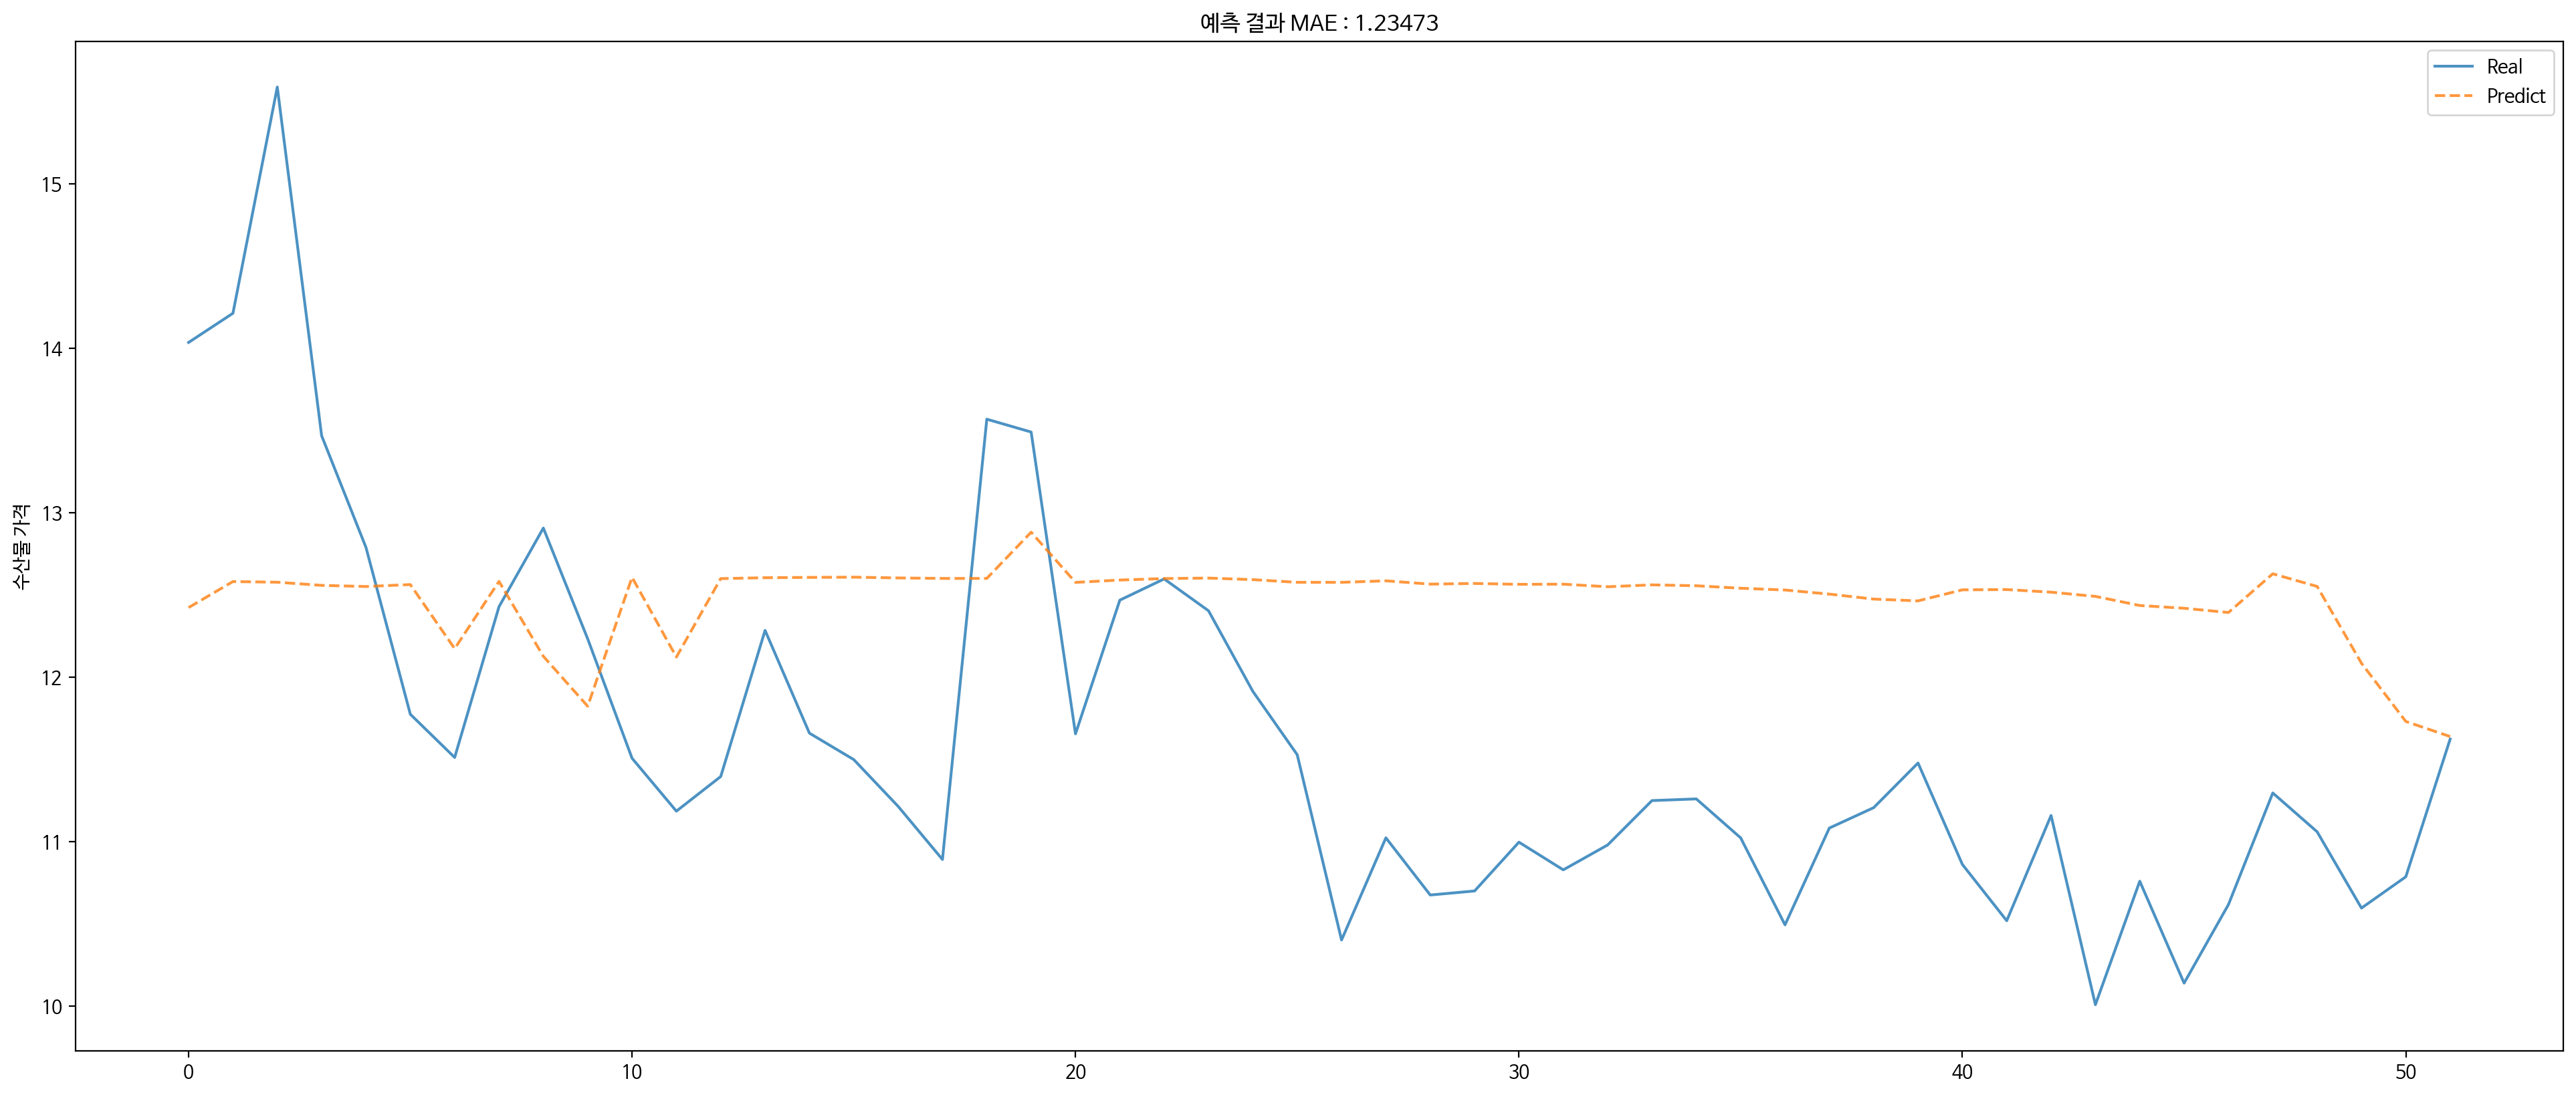

In [68]:
X = df_salmon_predict[['CTRY_1',	'CTRY_2',	'P_PURPOSE', 'P_IMPORT_TYPE',	'P_PRICE']].values.reshape(-1,1,5)
y = df_salmon20['P_PRICE']
y_pred = model.predict(X)


MAE = mean_absolute_error(y, y_pred.reshape(-1, 1))

plt.figure(figsize=(24, 10),dpi=200)
plt.title('예측 결과'+   ' MAE : ' + str(MAE)[:7])
plt.ylabel('수산물 가격')
plt.plot(np.array(y).reshape(-1,1), alpha = 0.8, label = 'Real')
plt.plot(y_pred.reshape(-1, 1), alpha = 0.8,linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

## 연어 가격 예측 정답
- 20년도 데이터를 input하여 21년도 연어 가격을 산출하여 최종 답안으로 제출

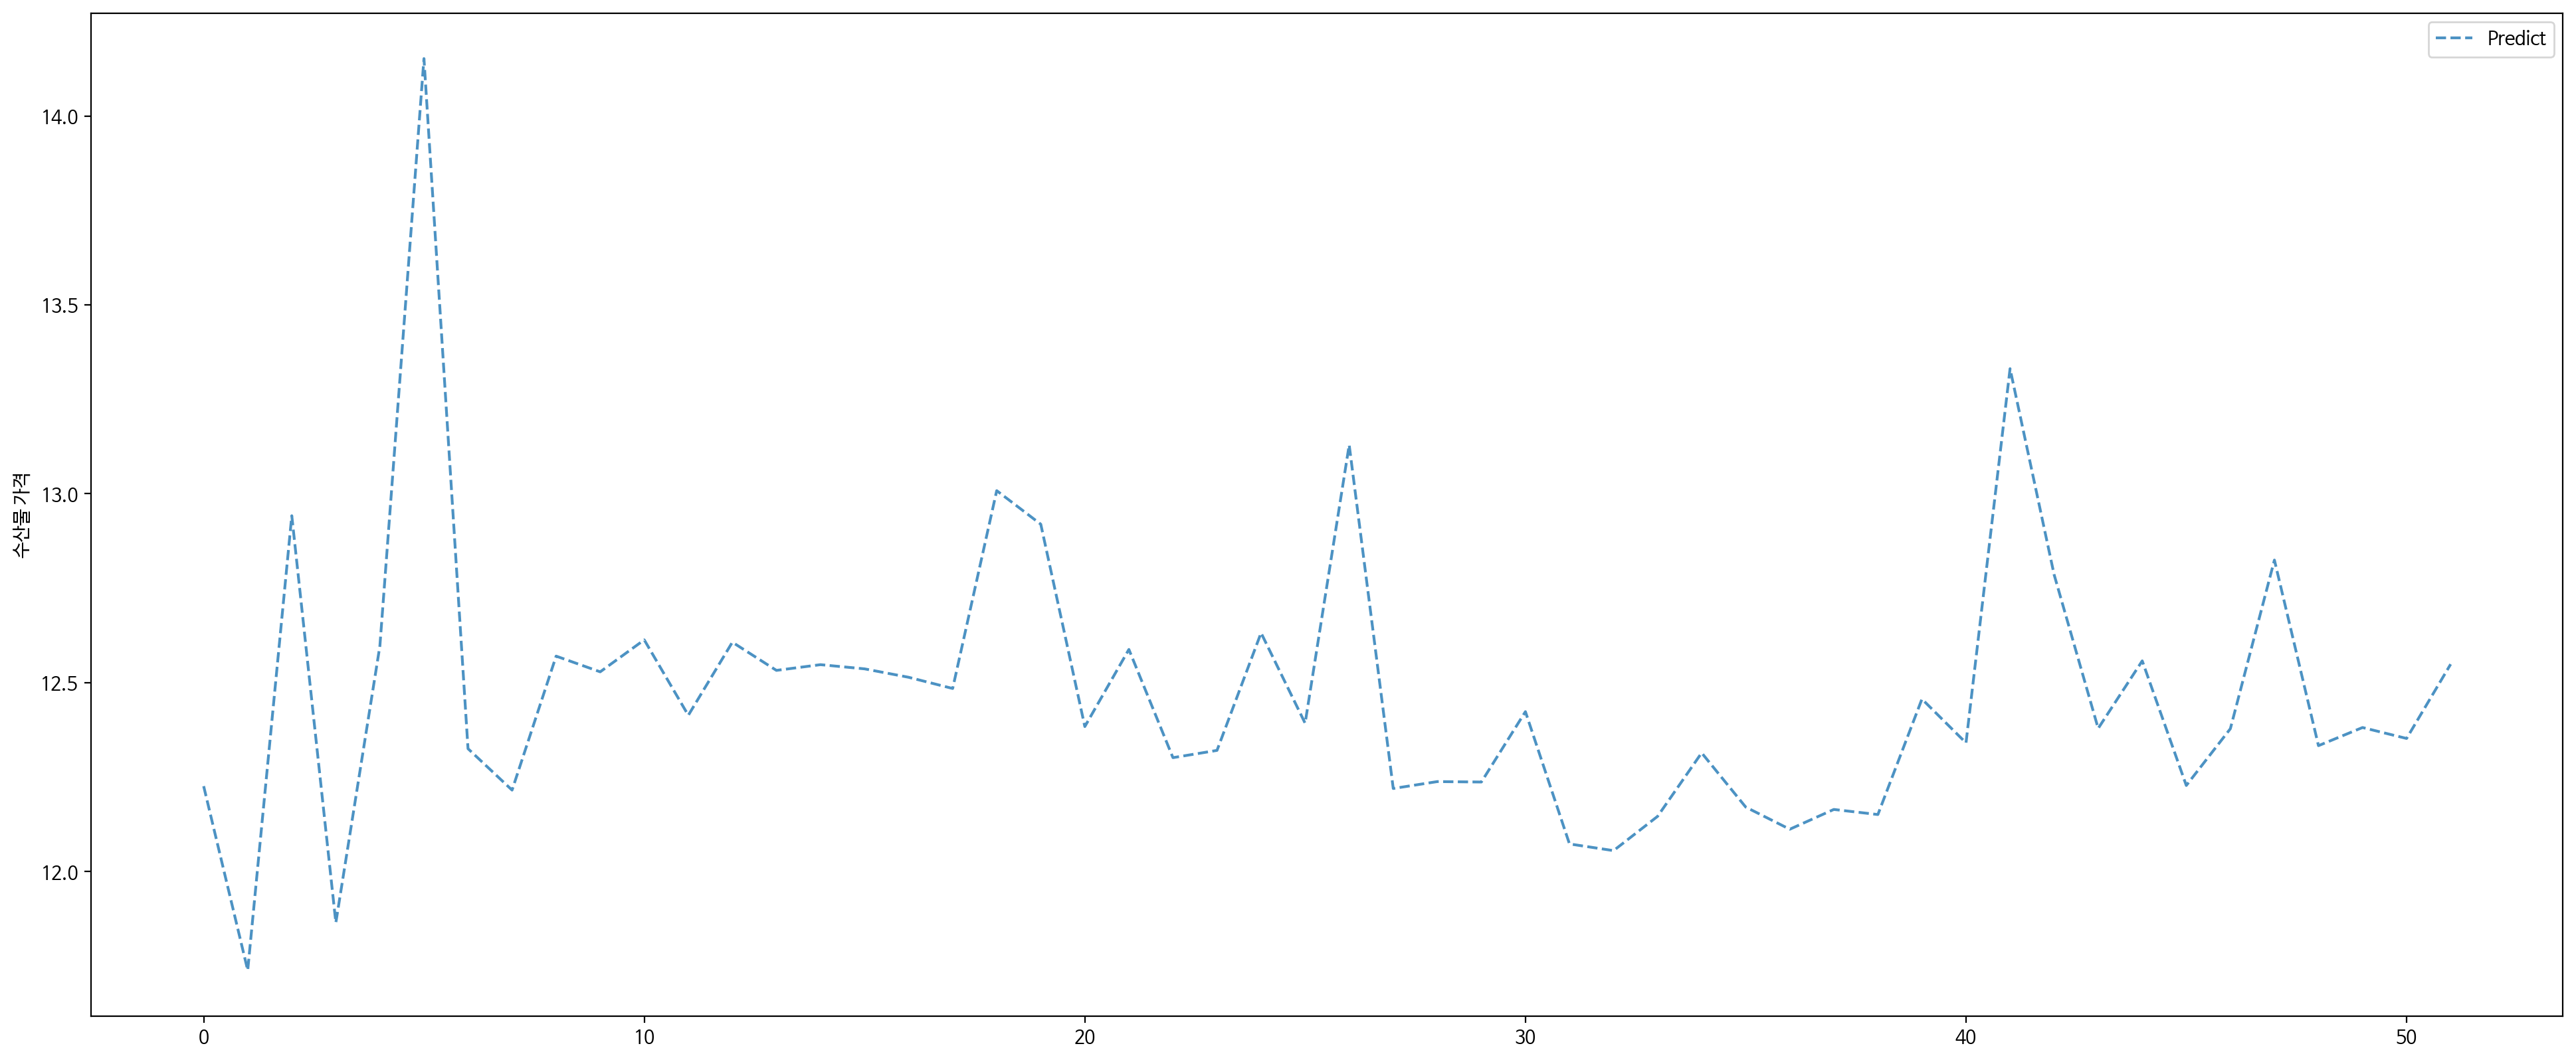

In [69]:
X = df_salmon20[['CTRY_1',	'CTRY_2',	'P_PURPOSE', 'P_IMPORT_TYPE',	'P_PRICE']].values.reshape(-1,1,5)
y_pred = model.predict(X)

plt.figure(figsize=(24, 10),dpi=200)
plt.ylabel('수산물 가격')
plt.plot(y_pred.reshape(-1, 1), alpha = 0.8,linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

- 2021년 6달의 연어 가격 정답

In [70]:
y_pred[:26]

array([[12.226155],
       [11.738839],
       [12.941884],
       [11.864798],
       [12.597519],
       [14.151761],
       [12.325335],
       [12.215668],
       [12.570293],
       [12.528723],
       [12.61331 ],
       [12.4137  ],
       [12.607134],
       [12.532559],
       [12.547703],
       [12.536609],
       [12.514321],
       [12.484663],
       [13.008266],
       [12.919378],
       [12.383861],
       [12.587986],
       [12.301582],
       [12.320815],
       [12.631791],
       [12.392652]], dtype=float32)

# 흰다리새우 가격 예측

## 데이터프레임에서 흰다리새우만 추출 후 이상치 제거 및 전처리
이상치 제거에는 IQR 방식을 사용함 이상치를 제거해도 된다고 판단한 이유는 미래에는 천재지변으로 인한 수산물 가격의 급등 혹은 급락이 없을 것이라고 가정한 후에 예측을 진행할 것이기 때문에 제거하기로 결정<br><br>
- 각 년도 별로 데이터가 수집된 일자가 다르기 때문에 월 별로 Week_Number(1년중 몇번째 주차인지)를 기준으로 데이터를 정렬해야 함
- 제공된 데이터 중 16년부터 19년의 데이터를 활용할 것이고 또한 2015년인 데이터는 오직 12월 28일의 데이터만 있기 때문에 활용하지 않으므로 제거해줌
- 년도 별로 수집된 데이터의 시작 요일이 다르므로 구분하여서 Week_Number을 산출하였음 ex) 16년과 17년의 데이터의 수집시작 요일은 일요일이나 18년과 19년의 데이터의 수집시작 요일은 월요일임

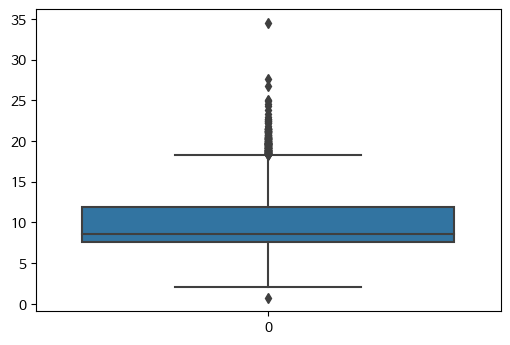

In [71]:
df_shrimp = df[df['P_NAME'] == '흰다리새우'].drop('CATEGORY_1', axis=1)

# 연어 가격의 boxplot을 통한 데이터 탐색
plt.figure(dpi=100)
sns.boxplot(data=df_shrimp['P_PRICE'].values)
plt.show()

In [72]:
quantile_25 = np.percentile(df_shrimp['P_PRICE'].values, 25)
quantile_75 = np.percentile(df_shrimp['P_PRICE'].values, 75)
weight = 1.5

IQR = quantile_75 - quantile_25
IQR_weight = IQR*weight
  
lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight
  
outlier_idx = df_shrimp['P_PRICE'][ (df_shrimp['P_PRICE'] < lowest) | (df_shrimp['P_PRICE'] > highest) ].index

df_shrimp.drop(outlier_idx, axis=0, inplace=True)
df_shrimp.reset_index(drop=True,inplace=True)

df_shrimp = df_shrimp[df_shrimp['REG_DATE'] != '2015-12-28']

df_shrimp['YEAR'] = pd.to_datetime(df_shrimp.REG_DATE).dt.year
df_shrimp['MONTH'] = pd.to_datetime(df_shrimp.REG_DATE).dt.month
df_shrimp16 = df_shrimp[df_shrimp['YEAR']== 2016]
df_shrimp17 = df_shrimp[df_shrimp['YEAR']== 2017]
df_shrimp18 = df_shrimp[df_shrimp['YEAR']== 2018]
df_shrimp19 = df_shrimp[df_shrimp['YEAR']== 2019]
df_shrimp16['Week_Number'] = df_shrimp16['REG_DATE'].dt.strftime('%U').astype(int)
df_shrimp17['Week_Number'] = df_shrimp17['REG_DATE'].dt.strftime('%U').astype(int)
df_shrimp18['Week_Number'] = df_shrimp18['REG_DATE'].dt.strftime('%W').astype(int)
df_shrimp19['Week_Number'] = df_shrimp19['REG_DATE'].dt.strftime('%W').astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

- 년도 별로 나누었던 데이터를 다시 병합한 후 시계열로 구분하기 쉽게 컬럼의 순서를 변경해주었주고 YEAR과 Week_Number를 기준으로 순서대로 정렬해주었음

In [73]:
df_shrimp = pd.concat([df_shrimp16,df_shrimp17,df_shrimp18,df_shrimp19])
df_shrimp = df_shrimp.reset_index(drop=True)

- 2018년도의 데이터만 53주차가 있으므로 53주차인 데이터를 제거(52주 기준으로 정렬하기 위함)
- 컬럼에서 Identifier가 아닌 CATEGORY_2, P_NAME, MONTH를 제거

In [74]:
df_shrimp = df_shrimp[['YEAR','MONTH','Week_Number','CTRY_1',"CTRY_2","CATEGORY_2"	,"P_NAME"	,	"P_PURPOSE",	"P_IMPORT_TYPE",	"P_PRICE"]]
df_shrimp = df_shrimp[df_shrimp['Week_Number'] != 53]
df_shrimp = df_shrimp.drop(['CATEGORY_2', 'P_NAME', 'MONTH'], axis=1)
df_shrimp

YEAR  Week_Number   CTRY_1   CTRY_2 P_PURPOSE P_IMPORT_TYPE    P_PRICE
0     2016            1       중국       중국       판매용       냉동,살,자숙   8.204321
1     2016            1       인도       인도       판매용            냉동   9.059677
2     2016            1    말레이시아    말레이시아       판매용            냉동   7.189045
3     2016            1  사우디아라비아  사우디아라비아       판매용            냉동   5.700000
4     2016            1      베트남      베트남       판매용     냉동,살,포장횟감  10.863794
...    ...          ...      ...      ...       ...           ...        ...
2413  2019           52    말레이시아    말레이시아       판매용            냉동   7.682474
2414  2019           52       태국       태국       판매용            냉장  11.500000
2415  2019           52     에콰도르     에콰도르       판매용            냉동   6.739527
2416  2019           52      베트남      베트남       판매용       냉동,살,자숙   7.701577
2417  2019           52      베트남      베트남       판매용          냉동,살   8.353018

[2408 rows x 7 columns]

- 새우 역시 각 년도 별로 추세를 확인해본 결과 특별한 추세가 없다고 판단되어 추세를 1달이라고 판단하였음

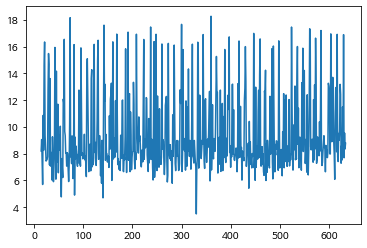

In [75]:
plt.plot(df_shrimp16['P_PRICE'])
plt.show()

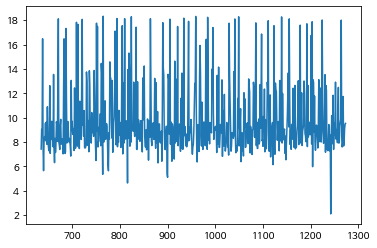

In [76]:
plt.plot(df_shrimp17['P_PRICE'])
plt.show()

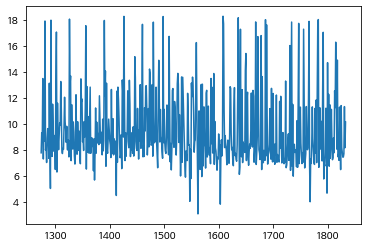

In [77]:
plt.plot(df_shrimp18['P_PRICE'])
plt.show()

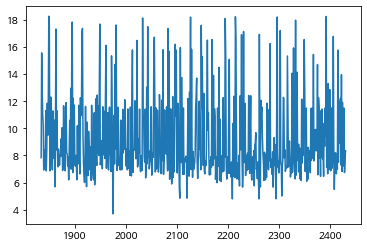

In [78]:
plt.plot(df_shrimp19['P_PRICE'])
plt.show()

## 라벨인코딩 작업
데이터프레임에서 가격을 예측하는 데 활용할 수 있는 feature가 모두 범주형 데이터(자연어)이므로 모델에 활용하기 위해 정수인코딩을 해주어야 함<br><br>
- df_shrimp에서 범주형 컬럼들의 값을 모두 text라는 하나의 공간에 담아서 단어를 토큰화 해준 뒤 1번 밖에 나타나지 않은 단어는 제거해주었음

In [79]:
text = df_shrimp[['CTRY_1',	'CTRY_2', 'P_PURPOSE',	'P_IMPORT_TYPE']].values
text[0]

array(['중국', '중국', '판매용', '냉동,살,자숙'], dtype=object)

- vocab은 중복을 제거한 단어와 각 단어에 대한 빈도수가 기록되어져 있음<br>
Key(단어) : Value(각 단어에 대한 빈도수)로 이루어진 dictionary임

In [80]:
vocab = {} # 파이썬의 dictionary 자료형
sentences = []

for i in text:
    sentence = i # 단어 토큰화를 수행합니다.
    result = []

    for word in sentence: 
        if len(word) > 0: # 단어 길이가 2이하인 경우에 대하여 추가로 단어를 제거합니다.
            result.append(word)
            if word not in vocab:
                vocab[word] = 0 
            vocab[word] += 1
    sentences.append(result) 
sentences[0]

['중국', '중국', '판매용', '냉동,살,자숙']

- vocab에서 빈도 수가 높은 순서대로 정렬을 진행

In [81]:
vocab

{'냉동': 737,
 '냉동,살': 609,
 '냉동,살,자숙': 352,
 '냉동,살,자숙,포장횟감': 194,
 '냉동,살,포장횟감': 188,
 '냉동,자숙': 158,
 '냉장': 170,
 '말레이시아': 378,
 '베트남': 1920,
 '사우디아라비아': 130,
 '에콰도르': 392,
 '인도': 206,
 '인도네시아': 118,
 '일본': 2,
 '자사제품제조용': 11,
 '중국': 314,
 '콜롬비아': 8,
 '태국': 1232,
 '파나마': 14,
 '판매용': 2397,
 '페루': 94,
 '필리핀': 8}

- vocab에서 빈도 수가 높은 순서대로 정렬을 진행

In [82]:
vocab_sorted = sorted(vocab.items(), key = lambda x:x[1], reverse = True)

- 높은 빈도 수를 가진 단어일수록 낮은 정수 인덱스를 부여함 또한 빈도 수가 1인 단어들은 제거

In [83]:
word_to_index = {}
i=0
for (word, frequency) in vocab_sorted :
    if frequency > 1 : # 정제(Cleaning) 챕터에서 언급했듯이 빈도수가 적은 단어는 제외한다.
        i=i+1
        word_to_index[word] = i
word_to_index

{'냉동': 4,
 '냉동,살': 5,
 '냉동,살,자숙': 8,
 '냉동,살,자숙,포장횟감': 11,
 '냉동,살,포장횟감': 12,
 '냉동,자숙': 14,
 '냉장': 13,
 '말레이시아': 7,
 '베트남': 2,
 '사우디아라비아': 15,
 '에콰도르': 6,
 '인도': 10,
 '인도네시아': 16,
 '일본': 22,
 '자사제품제조용': 19,
 '중국': 9,
 '콜롬비아': 21,
 '태국': 3,
 '파나마': 18,
 '판매용': 1,
 '페루': 17,
 '필리핀': 20}

- vocab에 존재하지 않는 단어들을 Out Of Vocabulary(OOV)라는 단어로 새롭게 추가하고, vocab에 없는 단어들을 OOV의 인덱스로 인코딩 함

In [84]:
word_to_index['OOV'] = len(word_to_index) + 1

- word_to_index를 사용하여 sentences의 모든 단어들을 맵핑되는 정수로 인코딩 후에 인코딩 된 값들로 df의 범주형 값들을 교체해 주었음

In [85]:
encoded = []
for s in sentences:
    temp = []
    for w in s:
        try:
            temp.append(word_to_index[w])
        except KeyError:
            temp.append(word_to_index['OOV'])
    encoded.append(temp)
encoded[0]

[9, 9, 1, 8]

In [86]:
df_shrimp[['CTRY_1',	'CTRY_2', 'P_PURPOSE',	'P_IMPORT_TYPE']] = encoded
df_shrimp

YEAR  Week_Number  CTRY_1  CTRY_2  P_PURPOSE  P_IMPORT_TYPE    P_PRICE
0     2016            1       9       9          1              8   8.204321
1     2016            1      10      10          1              4   9.059677
2     2016            1       7       7          1              4   7.189045
3     2016            1      15      15          1              4   5.700000
4     2016            1       2       2          1             12  10.863794
...    ...          ...     ...     ...        ...            ...        ...
2413  2019           52       7       7          1              4   7.682474
2414  2019           52       3       3          1             13  11.500000
2415  2019           52       6       6          1              4   6.739527
2416  2019           52       2       2          1              8   7.701577
2417  2019           52       2       2          1              5   8.353018

[2408 rows x 7 columns]

- YEAR와 Week_Number로 groupby를 진행 한 뒤 각 주차별로 평균을 산출하였음 빈도 수를 기준으로 인코딩 된 값들의 평균과 각 주차별로 평균으로 이루어진 값으로 df_shrimp를 재정의

In [87]:
df_shrimp = df_shrimp.groupby(['YEAR', 'Week_Number']).mean()

## 모델링
모델은 지난 1년 간의 데이터로 1년 후를 예측하는 모델이므로 Target은 1년 후의 실제 가격임
- 모델에서 흰다리새우의 추세를 반영하기 위하여 Input_shape로 들어갈 때 4주(1달)로 input을 진행

In [88]:
df_shrimp['P_PRICE'].shift(-52)

YEAR  Week_Number
2016  1               8.846389
      2               8.560516
      3              10.161406
      4               9.918257
      5               8.798259
      6              10.229580
      7              10.481363
      8               9.315327
      9               9.577002
      10             10.246658
      11             10.020274
      12              9.584225
      13             10.590919
      14             10.690844
      15             10.673252
      16             10.416354
      17              8.878134
      18              9.442839
      19              9.879027
      20              9.285064
      21              9.801100
      22              9.861784
      23              9.981567
      24             10.166390
      25              9.538551
      26              9.736112
      27             10.028152
      28             10.810055
      29             10.563243
      30              9.306187
      31              9.004336
      32             

In [89]:
df_shrimp['Target'] = df_shrimp['P_PRICE'].shift(-52)
df_shrimp

CTRY_1    CTRY_2  P_PURPOSE  P_IMPORT_TYPE    P_PRICE  \
YEAR Week_Number                                                            
2016 1            5.076923  5.076923   2.384615       6.461538   9.279109   
     2            3.666667  3.666667   1.000000       6.916667   9.845644   
     3            4.076923  4.076923   1.000000       7.461538   9.308712   
     4            5.500000  5.500000   1.000000       6.937500   8.813216   
     5            5.454545  5.454545   1.000000       6.727273   8.748914   
     6            3.625000  3.625000   1.000000       8.125000   8.533956   
     7            4.666667  4.666667   1.000000       6.666667   9.093007   
     8            3.666667  3.666667   1.000000       6.333333   8.024025   
     9            3.300000  3.300000   1.000000       8.100000   9.596492   
     10           3.900000  3.900000   1.000000       6.700000   9.754878   
     11           3.800000  3.800000   1.000000       8.400000   9.919891   
     12           5.428571  5.428571   2.285714       6.500000   9.074188   
     13           5.500000  5.500000   1.000000       6.875000   9.313208   
     14           4.538462  4.538462   1.000000       7.461538   9.263328   
     15           4.700000  4.700000   1.000000       6.700000   9.402779   
     16           5.538462  5.538462   1.000000       6.692308   9.427259   
     17           4.545455  4.545455   1.000000       7.272727   9.906397   
     18           3.000000  3.000000   1.000000       6.800000   9.147936   
     19           4.400000  4.400000   1.000000       7.400000   9.104018   
     20           4.571429  4.571429   1.000000       7.285714   9.428062   
     21           5.000000  5.000000   1.000000       7.461538   9.453689   
     22           4.500000  4.500000   1.000000       7.000000   9.093815   
     23           6.285714  6.285714   1.000000       6.571429   9.020195   
     24           6.533333  6.533333   1.000000       6.400000   8.859819   
     25           4.466667  4.466667   1.000000       7.733333   9.857831   
     26           3.727273  3.727273   1.000000       8.000000   9.241334   
     27           3.222222  3.222222   1.000000       7.222222   9.149257   
     28           5.500000  5.500000   1.000000       6.875000   9.104856   
     29           3.727273  3.727273   1.000000       7.454545   9.675564   
     30           5.153846  5.153846   1.000000       6.769231   9.586473   
     31           4.250000  4.250000   1.000000       7.250000  10.139484   
     32           4.153846  4.153846   1.000000       7.230769   9.075163   
     33           3.222222  3.222222   1.000000       6.777778  10.229765   
     34           3.900000  3.900000   1.000000       5.900000   9.269230   
     35           4.272727  4.272727   1.000000       7.272727   9.424748   
     36           7.000000  7.000000   1.000000       5.928571   9.393843   
     37           3.000000  3.000000   1.000000       7.833333   7.907978   
     38           7.666667  7.666667   1.000000       5.750000   8.835214   
     39           3.600000  3.600000   1.000000       7.500000  10.147765   
     40           6.272727  6.272727   1.000000       5.727273   8.892773   
     41           6.812500  6.812500   1.000000       6.750000   9.228031   
     42           5.333333  5.333333   1.000000       7.166667   8.973131   
     43           5.428571  5.428571   1.000000       6.785714   8.767965   
     44           4.916667  4.916667   1.000000       7.333333   9.435728   
     45           5.538462  5.538462   1.000000       6.692308   9.830964   
     46           3.916667  3.916667   1.000000       7.750000  10.096328   
     47           4.615385  4.615385   1.000000       7.692308  10.023136   
     48           3.909091  3.909091   1.000000       7.545455  10.106054   
     49           5.076923  5.076923   1.000000       7.384615   9.268170   
     50           6.437500  6.437500   1.000000       6.812500   9.696395   
     51         

- 16,17,18년 데이터로 각각 1년 후를 예측하는 모델을 만들고 그 모델에 19년도의 데이터를 넣어서 20년을 예측

In [90]:
df_shrimp_learn = df_shrimp[df_shrimp['Target'].notnull()]
df_shrimp_predict = df_shrimp[df_shrimp['Target'].isnull()]
X = df_shrimp_learn[['CTRY_1',	'CTRY_2',	'P_PURPOSE', 'P_IMPORT_TYPE',	'P_PRICE']].values.reshape(-1,1,5)
y = df_shrimp_learn['Target'].values.reshape(-1,1,1)

- 가격은 모두 달러로 나타나며 예측하려는 값도 동일한 단위이므로 스케일링을 진행하지 않았음<br>
시계열적 특성을 반영하기 위해서 LSTM 모델을 사용하였고 추세를 반영하기 위해 Input_shape는 행(4주)1달,열(Feature 갯수=5개)로 투입하였음


In [91]:
with tf.device('/device:GPU:0'):
  model = Sequential()
  model.add(layers.LSTM(100, input_shape=(4,5), activation='relu'))
  model.add(layers.Dense(30))
  model.add(layers.Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.fit(X, y, epochs=1000, batch_size=50)

  # model.save("shrimp.h5")
  model = tf.keras.models.load_model("/content/gdrive/MyDrive/data/shrimp.h5")

Epoch 1/1000
4/4 [==============================] - 1s 9ms/step - loss: 91.1127
Epoch 2/1000
4/4 [==============================] - 0s 8ms/step - loss: 80.1420
Epoch 3/1000
4/4 [==============================] - 0s 9ms/step - loss: 68.8770
Epoch 4/1000
4/4 [==============================] - 0s 8ms/step - loss: 56.6014
Epoch 5/1000
4/4 [==============================] - 0s 8ms/step - loss: 43.0174
Epoch 6/1000
4/4 [==============================] - 0s 10ms/step - loss: 28.5399
Epoch 7/1000
4/4 [==============================] - 0s 8ms/step - loss: 14.7078
Epoch 8/1000
4/4 [==============================] - 0s 9ms/step - loss: 4.5779
Epoch 9/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.2295
Epoch 10/1000
4/4 [==============================] - 0s 9ms/step - loss: 3.6927
Epoch 11/1000
4/4 [==============================] - 0s 10ms/step - loss: 4.4213
Epoch 12/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.4909
Epoch 13/1000
4/4 [====================

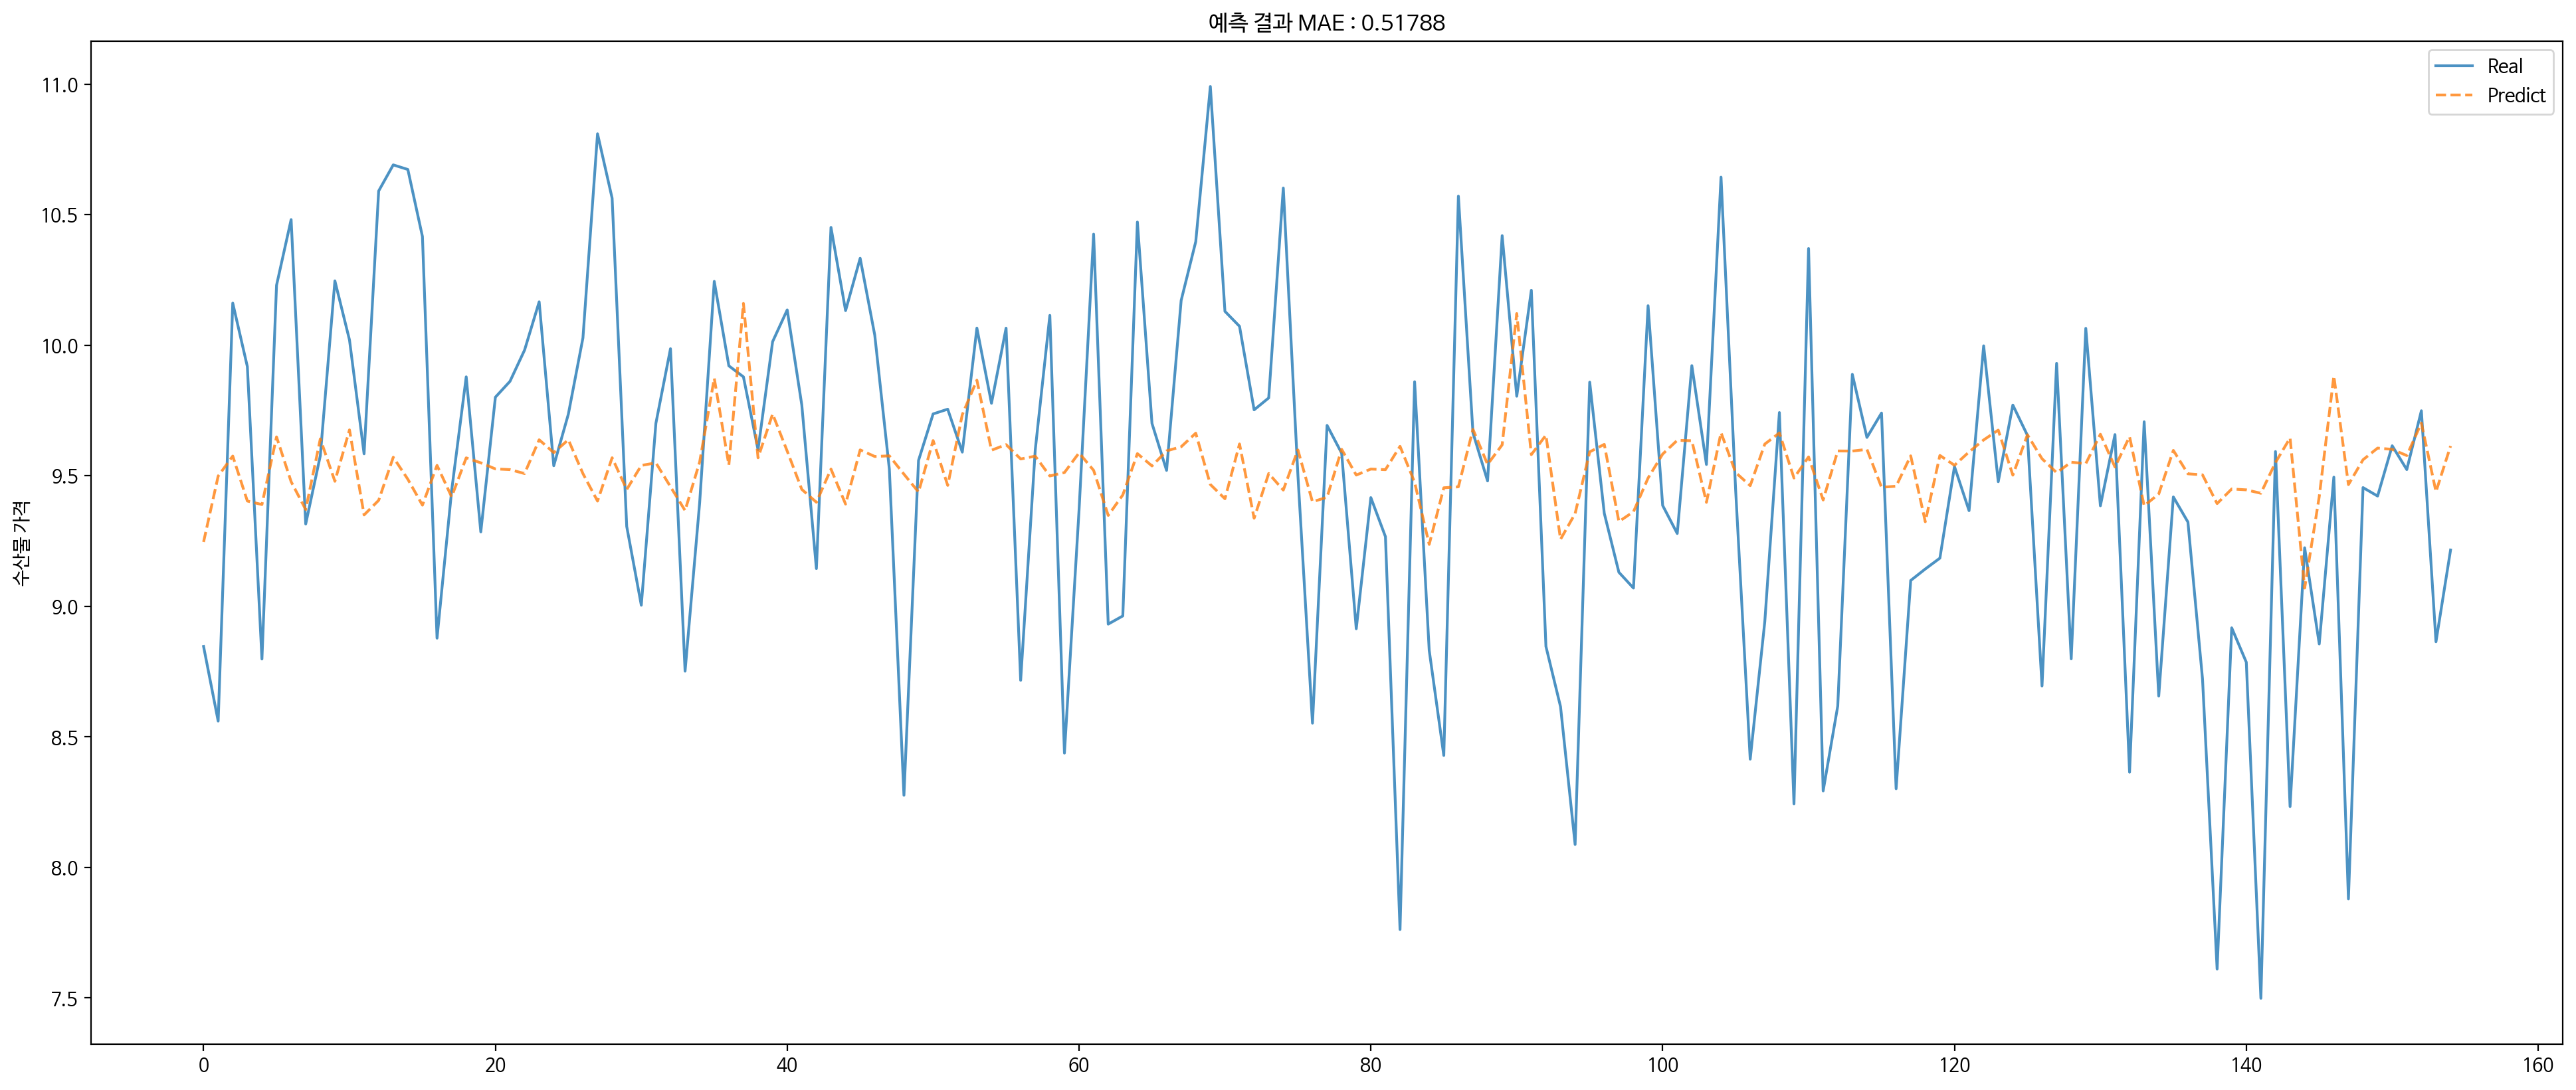

In [92]:
y_pred = model.predict(X)

MAE = mean_absolute_error(y.reshape(-1,1), y_pred.reshape(-1, 1))

plt.figure(figsize=(24, 10),dpi=200)
plt.title('예측 결과'+   ' MAE : ' + str(MAE)[:7])
plt.ylabel('수산물 가격')
plt.plot(np.array(y).reshape(-1,1), alpha = 0.8, label = 'Real')
plt.plot(y_pred.reshape(-1, 1), alpha = 0.8,linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

## Input데이터인 20년도 데이터프레임 정의 및 전처리

- 20년도 데이터에서 흰다리새우만을 추출하여 이상치를 IQR로 제거하고 주차별로 정렬하기 위한 전처리 작업 수행

In [93]:
df_shrimp20 = df20[df20['P_NAME'] == '흰다리새우'].drop('CATEGORY_1', axis=1)

quantile_25 = np.percentile(df_shrimp20['P_PRICE'].values, 25)
quantile_75 = np.percentile(df_shrimp20['P_PRICE'].values, 75)
weight = 1.5

IQR = quantile_75 - quantile_25
IQR_weight = IQR*weight
  
lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight
  
outlier_idx = df_shrimp20['P_PRICE'][ (df_shrimp20['P_PRICE'] < lowest) | (df_shrimp20['P_PRICE'] > highest) ].index

df_shrimp20.drop(outlier_idx, axis=0, inplace=True)
df_shrimp20.reset_index(drop=True,inplace=True)

df_shrimp20['YEAR'] = pd.to_datetime(df_shrimp20.REG_DATE).dt.year
df_shrimp20['MONTH'] = pd.to_datetime(df_shrimp20.REG_DATE).dt.month

df_shrimp20['Week_Number'] = df_shrimp20['REG_DATE'].dt.strftime('%U').astype(int)


In [94]:
df_shrimp20 = df_shrimp20[['YEAR','MONTH','Week_Number','CTRY_1',"CTRY_2","CATEGORY_2"	,"P_NAME"	,	"P_PURPOSE",	"P_IMPORT_TYPE",	"P_PRICE"]]
df_shrimp20 = df_shrimp20.drop(['CATEGORY_2', 'P_NAME', 'MONTH'], axis=1)
df_shrimp20

YEAR  Week_Number CTRY_1 CTRY_2 P_PURPOSE P_IMPORT_TYPE    P_PRICE
0    2020            1     태국     태국       판매용          냉동,살  11.519824
1    2020            1     태국     태국       판매용         냉동,자숙   8.056061
2    2020            1    베트남    베트남       판매용  냉동,살,자숙,포장횟감   9.690003
3    2020            1    베트남    베트남       판매용         냉동,자숙   8.013686
4    2020            1  말레이시아  말레이시아       판매용            냉동   7.286303
..    ...          ...    ...    ...       ...           ...        ...
509  2020           52    베트남    베트남       판매용       냉동,살,자숙   7.830000
510  2020           52    베트남    베트남       판매용  냉동,살,자숙,포장횟감  16.770000
511  2020           52     페루     페루       판매용            냉동   6.140000
512  2020           52     태국     태국       판매용          냉동,살   9.620000
513  2020           52    베트남    베트남       판매용          냉동,살   7.410000

[514 rows x 7 columns]

- 20년도 흰다리새우 가격의 추세 확인을 위한 그래프를 그렸으며 동일하게 1달의 추세가 있다고 판단

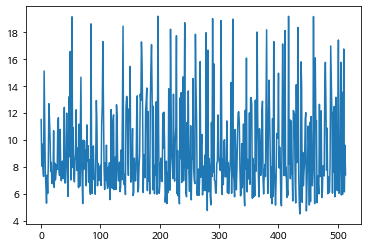

In [95]:
plt.plot(df_shrimp20['P_PRICE'])
plt.show()

- 위에서 인코딩한 데이터를 끌어와서 빈도 수 기준으로 동일하게 인코딩 후 범주형 데이터 재정의

In [96]:
text = df_shrimp20[['CTRY_1',	'CTRY_2', 'P_PURPOSE',	'P_IMPORT_TYPE']].values
text[0]

array(['태국', '태국', '판매용', '냉동,살'], dtype=object)

In [97]:
sentences = []

for i in text:
    sentence = i # 단어 토큰화를 수행합니다.
    result = []

    for word in sentence: 
        if len(word) > 0: # 단어 길이가 2이하인 경우에 대하여 추가로 단어를 제거합니다.
            result.append(word)            
    sentences.append(result) 
sentences[0]

['태국', '태국', '판매용', '냉동,살']

In [98]:
encoded = []
for s in sentences:
    temp = []
    for w in s:
        try:
            temp.append(word_to_index[w])
        except KeyError:
            temp.append(word_to_index['OOV'])
    encoded.append(temp)
encoded[0]

[3, 3, 1, 5]

In [99]:
df_shrimp20[['CTRY_1',	'CTRY_2', 'P_PURPOSE',	'P_IMPORT_TYPE']] = encoded
df_shrimp20

YEAR  Week_Number  CTRY_1  CTRY_2  P_PURPOSE  P_IMPORT_TYPE    P_PRICE
0    2020            1       3       3          1              5  11.519824
1    2020            1       3       3          1             14   8.056061
2    2020            1       2       2          1             11   9.690003
3    2020            1       2       2          1             14   8.013686
4    2020            1       7       7          1              4   7.286303
..    ...          ...     ...     ...        ...            ...        ...
509  2020           52       2       2          1              8   7.830000
510  2020           52       2       2          1             11  16.770000
511  2020           52      17      17          1              4   6.140000
512  2020           52       3       3          1              5   9.620000
513  2020           52       2       2          1              5   7.410000

[514 rows x 7 columns]

- Year와 Week_Number로 groupby한 평균 값으로 df_shrimp20을 재정의

In [100]:
df_shrimp20 = df_shrimp20.groupby(['YEAR', 'Week_Number']).mean()
df_shrimp20

CTRY_1    CTRY_2  P_PURPOSE  P_IMPORT_TYPE    P_PRICE
YEAR Week_Number                                                         
2020 1            5.076923  5.076923        1.0       8.615385   8.615585
     2            4.363636  4.363636        1.0       7.181818   8.796236
     3            5.250000  5.250000        1.0       6.833333   8.517533
     4            3.444444  3.444444        1.0       7.888889   8.790891
     5            5.785714  5.785714        1.0       7.357143  10.152567
     6            4.700000  4.700000        1.0       7.500000   9.602708
     7            4.875000  4.875000        1.0       7.000000   8.055583
     8            5.000000  5.000000        1.0       7.444444   9.404249
     9            7.272727  7.272727        1.0       6.000000   8.408668
     10           4.750000  4.750000        1.0       7.500000   9.432711
     11           6.428571  6.428571        1.0       6.000000   7.524589
     12           7.600000  7.600000        1.0       6.000000   8.423968
     13           6.100000  6.100000        1.0       5.200000   8.274131
     14           5.363636  5.363636        1.0       7.090909  10.347395
     15           5.727273  5.727273        1.0       6.454545   9.145134
     16           7.222222  7.222222        1.0       5.333333   8.588887
     17           2.875000  2.875000        1.0       8.000000  11.910210
     18           5.222222  5.222222        1.0       6.777778   9.475345
     19           4.444444  4.444444        1.0       7.555556  11.037321
     20           5.300000  5.300000        1.0       6.600000   9.711227
     21           6.444444  6.444444        1.0       5.777778   8.534547
     22           6.600000  6.600000        1.0       6.400000   9.898780
     23           5.300000  5.300000        1.0       6.800000   9.469158
     24           5.000000  5.000000        1.0       7.307692   9.917841
     25           4.600000  4.600000        1.0       8.100000   8.591011
     26           5.583333  5.583333        1.0       7.083333   9.593612
     27           6.000000  6.000000        1.0       6.250000   8.796752
     28           6.090909  6.090909        1.0       7.363636   9.387848
     29           5.833333  5.833333        1.0       7.333333   9.065850
     30           4.111111  4.111111        1.0       7.222222  10.181265
     31           5.300000  5.300000        1.0       5.900000   8.033724
     32           5.500000  5.500000        1.0       6.250000   9.520660
     33           4.700000  4.700000        2.8       6.600000   8.949955
     34           5.600000  5.600000        1.0       7.200000   8.729689
     35           4.222222  4.222222        1.0       7.222222   9.575920
     36           4.875000  4.875000        1.0       7.875000  10.178609
     37           4.916667  4.916667        2.5       6.666667   8.530366
     38           4.700000  4.700000        1.0       7.200000  10.598746
     39           5.857143  5.857143        1.0       6.000000   8.941142
     40           5.100000  5.100000        2.8       7.500000   8.918171
     41           5.100000  5.100000        1.0       6.400000  10.193886
     42           5.400000  5.400000        1.0       7.200000   9.041853
     43           4.454545  4.454545        1.0       7.818182  10.351185
     44           6.909091  6.909091        1.0       6.363636   9.166598
     45           5.571429  5.571429        1.0       6.428571   8.153888
     46           4.000000  4.000000        1.0       5.200000   7.972717
     47           3.500000  3.500000        1.0       7.000000  10.624039
     48           5.571429  5.571429        1.0       6.000000   8.763610
     49           4.800000  4.800000        1.0       7.400000   9.613453
     50           5.500000  5.500000        1.0       6.500000   9.701769
     51           5.500000  5.500000        1.0       7.200000   9.889389
     52           6.000000  6.000000        1.0       6.600000   9.757000

- 19년도 데이터를 이용하여 20년도 가격을 예측

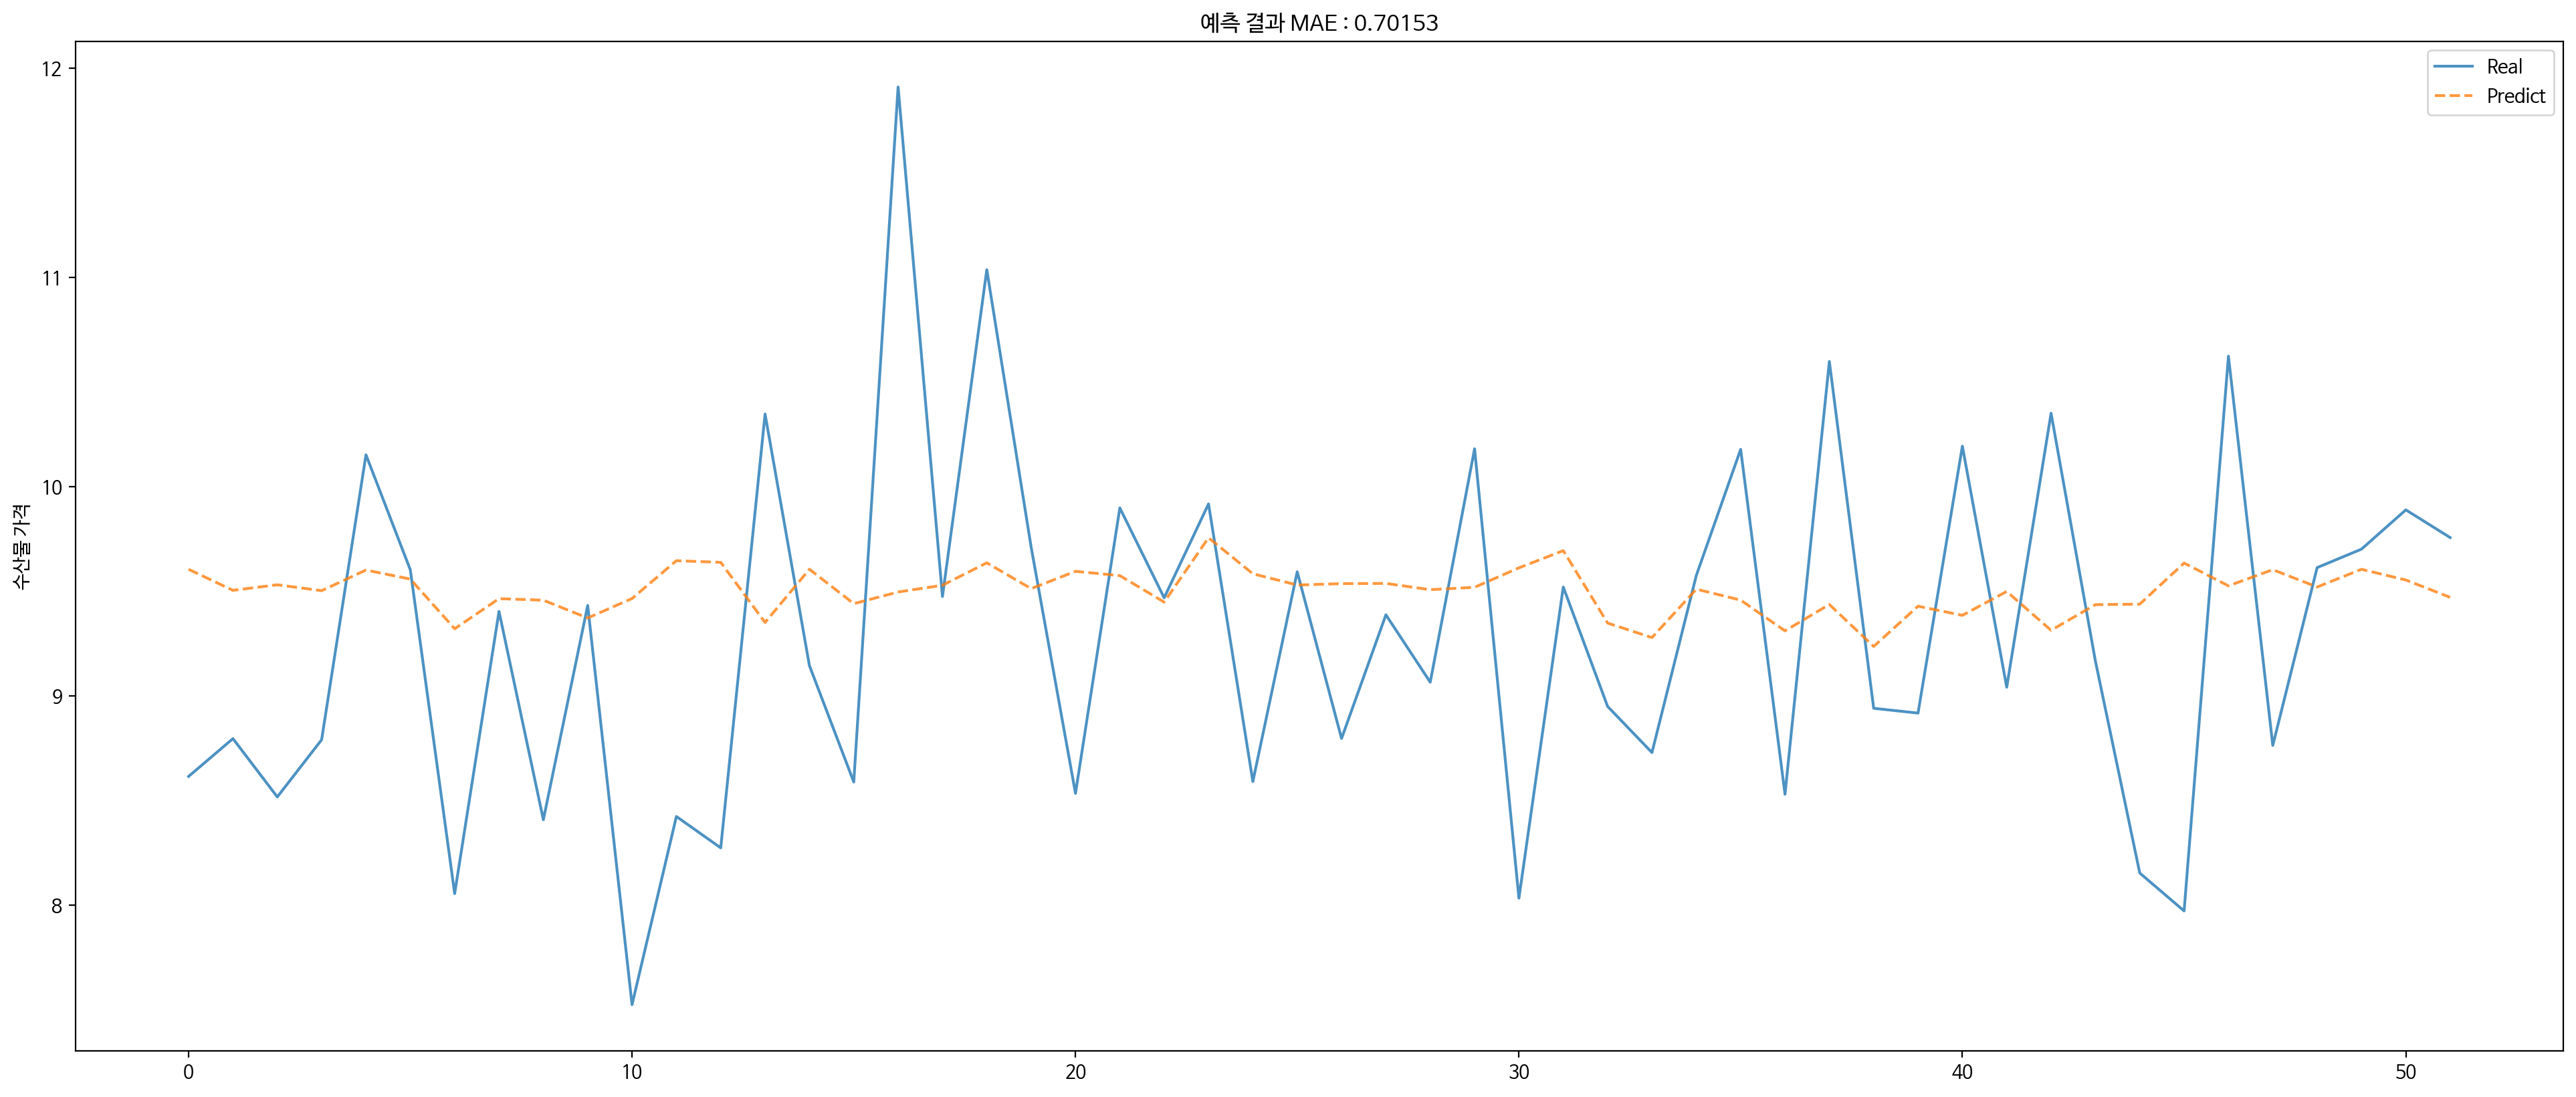

In [101]:
X = df_shrimp_predict[['CTRY_1',	'CTRY_2',	'P_PURPOSE', 'P_IMPORT_TYPE',	'P_PRICE']].values.reshape(-1,1,5)
y = df_shrimp20['P_PRICE']
y_pred = model.predict(X)


MAE = mean_absolute_error(y, y_pred.reshape(-1, 1))

plt.figure(figsize=(24, 10),dpi=200)
plt.title('예측 결과'+   ' MAE : ' + str(MAE)[:7])
plt.ylabel('수산물 가격')
plt.plot(np.array(y).reshape(-1,1), alpha = 0.8, label = 'Real')
plt.plot(y_pred.reshape(-1, 1), alpha = 0.8,linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

## 흰다리새우 가격 예측 정답
- 20년도 데이터를 input하여 21년도 흰다리새우 가격을 산출하여 최종 답안으로 제출

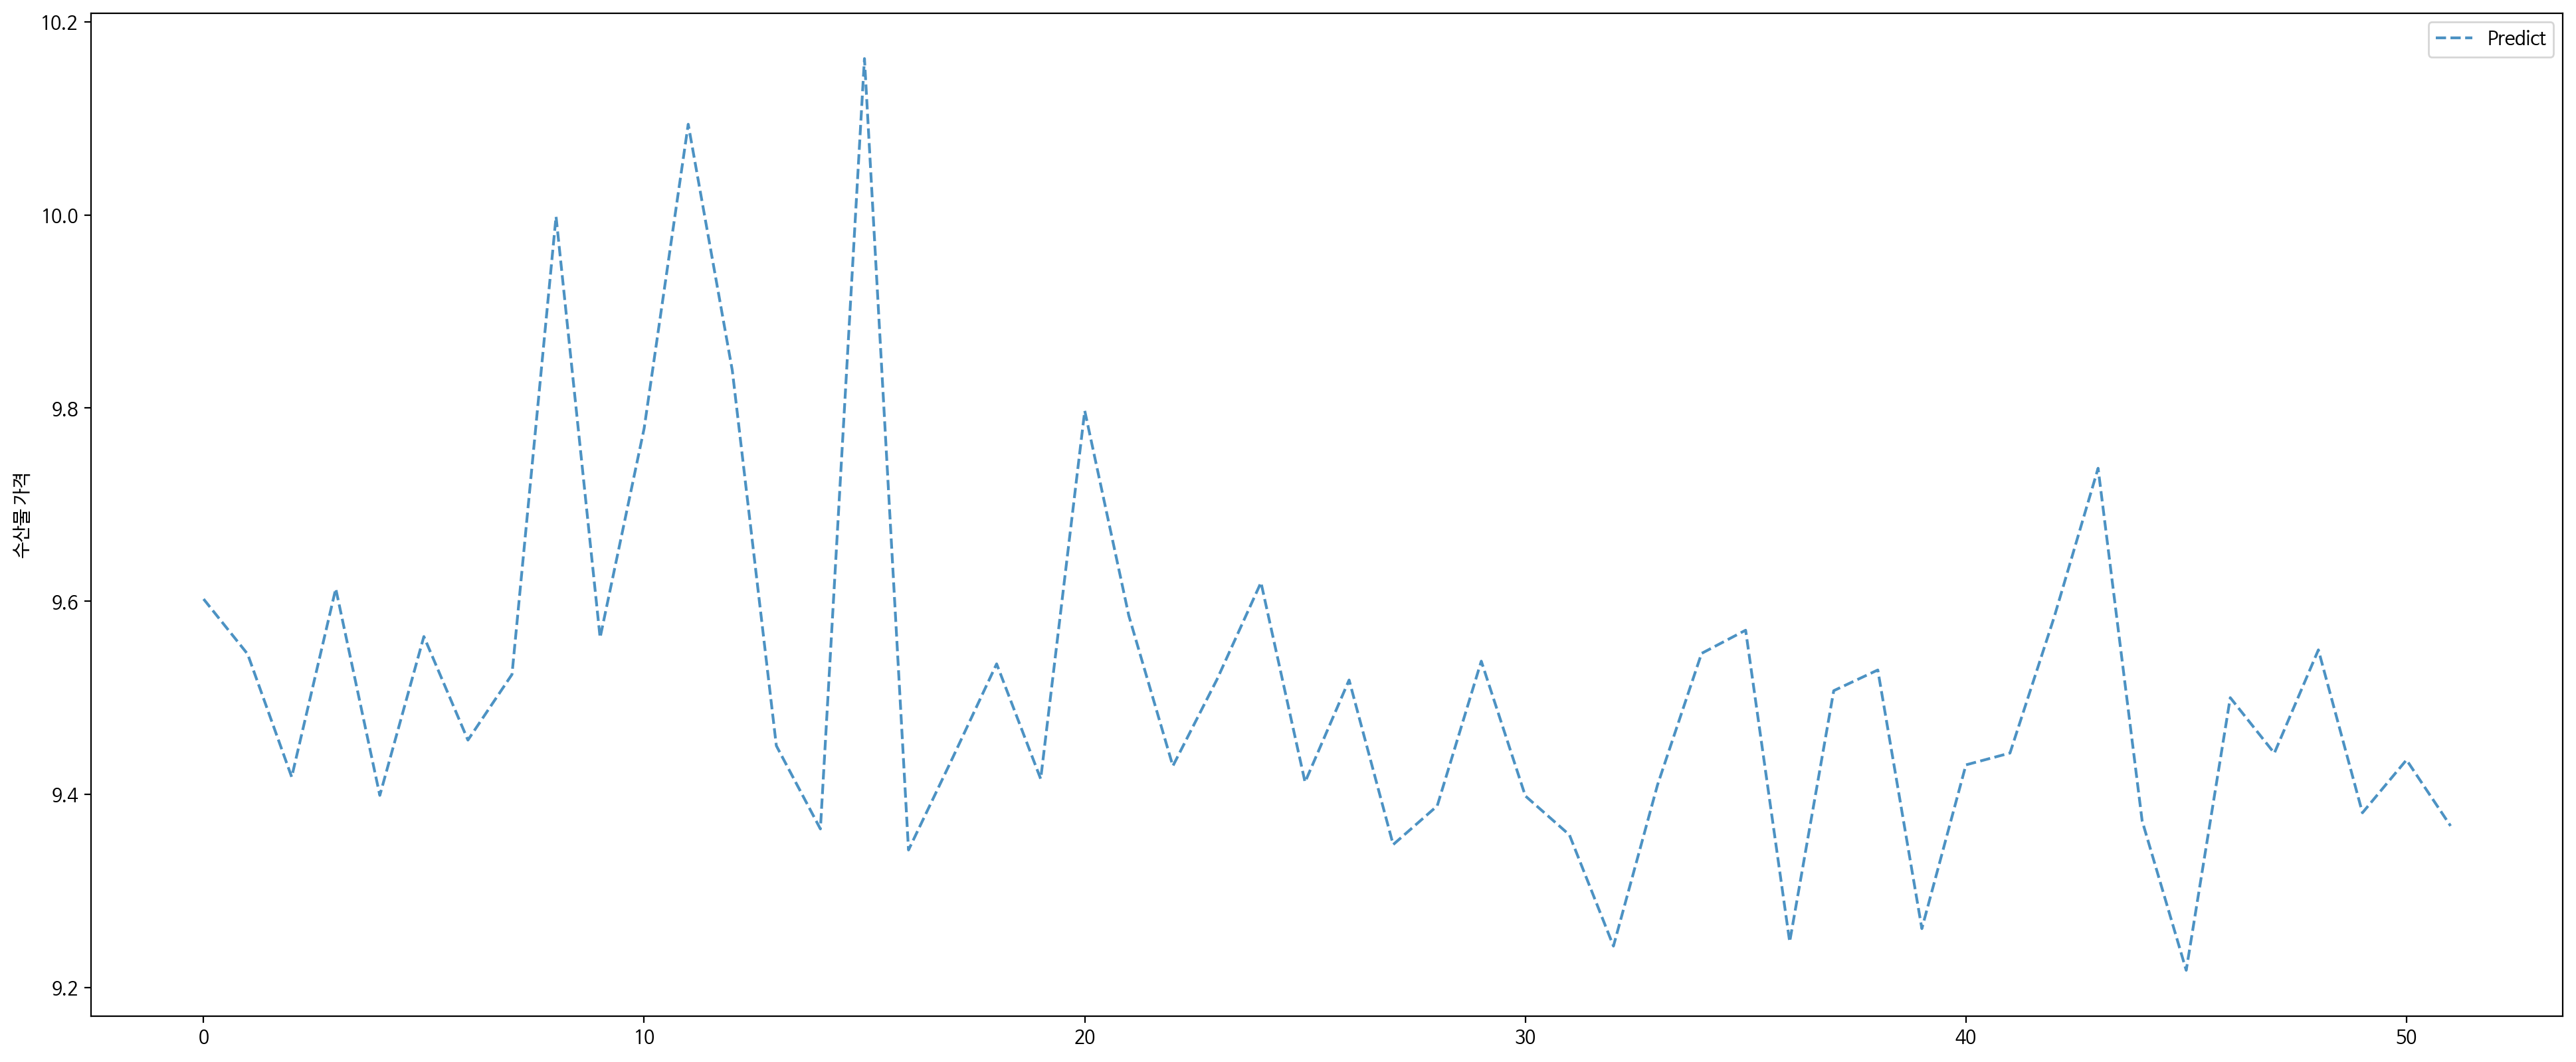

In [102]:
X = df_shrimp20[['CTRY_1',	'CTRY_2',	'P_PURPOSE', 'P_IMPORT_TYPE',	'P_PRICE']].values.reshape(-1,1,5)
y_pred = model.predict(X)


plt.figure(figsize=(24, 10),dpi=200)
plt.ylabel('수산물 가격')
plt.plot(y_pred.reshape(-1, 1), alpha = 0.8,linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

- 2021년 6달의 흰다리새우 가격 정답

In [103]:
y_pred[:26]

array([[ 9.602226],
       [ 9.545191],
       [ 9.417905],
       [ 9.612973],
       [ 9.398863],
       [ 9.563387],
       [ 9.45614 ],
       [ 9.524134],
       [ 9.998379],
       [ 9.562173],
       [ 9.779091],
       [10.093937],
       [ 9.839126],
       [ 9.450276],
       [ 9.364107],
       [10.161958],
       [ 9.342306],
       [ 9.437617],
       [ 9.535079],
       [ 9.415905],
       [ 9.797186],
       [ 9.585009],
       [ 9.429301],
       [ 9.518797],
       [ 9.619355],
       [ 9.412583]], dtype=float32)